# 0.0. IMPORTS

In [1]:
import math 
import numpy as np
import pandas as pd
import pickle
import inflection
import datetime
import random
import warnings
warnings.filterwarnings( 'ignore' )


import xgboost as xgb
import seaborn as sns
from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from tabulate              import tabulate
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error

In [2]:
xgb.__version__

'0.90'

## 0.1. Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1,kfold+1 ) ):
        if verbose:
            print( '\nKfold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)
            
         #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
            
        #training and validation dataset
        #training
        xtraining = training.drop( ['date', 'sales'], axis=1)
        ytraining = training['sales']
            
        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1)
        yvalidation = validation['sales']
            
        # model
        m = model.fit( xtraining, ytraining )
            
        #prediction
        yhat = m.predict( xvalidation )
            
        #performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
            
        # store performance of each kfold iteration
        mae_list.append( m_result[ 'MAE' ] )
        mape_list.append( m_result[ 'MAPE' ] ) 
        rmse_list.append( m_result[ 'RMSE' ] )
            
    return pd.DataFrame( {'Model Name' : model_name,
                            'MAE CV' : np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std(mae_list ), 2 ).astype( str ),
                            'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std(mape_list ), 2 ).astype( str ),
                            'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std(rmse_list ), 2 ).astype( str )}, index=[0] )
            

    
def mean_percentage_error( y, yhat):
    return np.mean( (y - yhat) / y )   
        
    
def mean_absolute_percentage_error( y, yhat):
    return np.mean( np.abs((y - yhat) / y ))

def ml_error( model_name, y , yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error( y, yhat))
    
    return pd.DataFrame ( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0])


def cramer_v(x,y):
    cm = pd.crosstab( x,y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False)

In [5]:
#merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [6]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
102600,21,4,2015-04-30,8076,685,1,1,0,0,c,c,550.0,10.0,1999.0,1,45.0,2009.0,"Jan,Apr,Jul,Oct"


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [31]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [10]:
print ( 'Number of Rows: {}' .format(df1.shape[0] ) )
print ( 'Number of Cols: {}' .format(df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [11]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
983248,604,4,2013-01-31,7652,600,1,0,0,0,d,a,10950.0,3.0,2014.0,0,NaN,NaN,NaN


In [14]:
#competition_distance   
df1.competition_distance.fillna(200000., inplace=True)

#competition_open_since_month 
df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

#competition_open_since_year
df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

#promo2_since_week
df1.promo2_since_week.fillna(df1.date.dt.isocalendar().week, inplace=True)

#promo2_since_year
df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

# substitui os 0 para '', assim não será necessário um dos if's do is_promo
df1['promo_interval'].replace(0, '', inplace=True)
# mesmo aqui
df1['promo_interval'].fillna('', inplace=True) 

# obtem a abreviatura do mês
df1['month_map'] = df1['date'].dt.strftime("%b") 

# como não tem 0's mais, tudo vai ser string, então podemos remover aqueles if's
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

## 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int32
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

df1['is_promo'] = df1['is_promo'].astype( 'int64' )

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m.head(5)

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723


### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

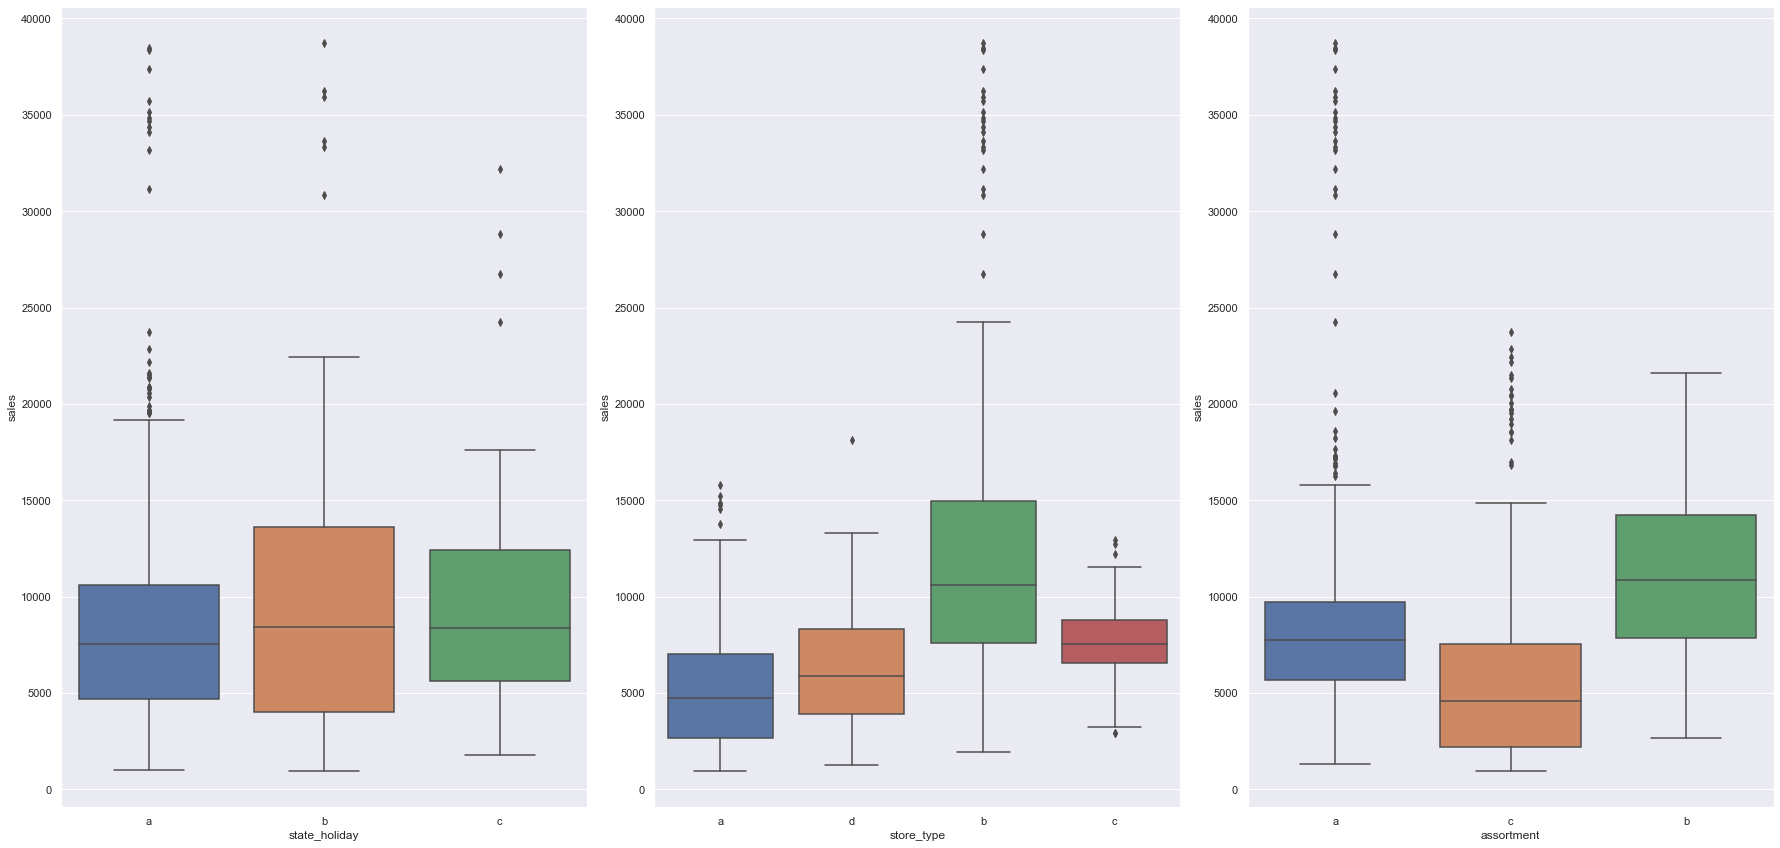

In [20]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)] 

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data= aux1)

plt.subplot(1,3,3)
plt.tight_layout()
sns.boxplot( x='assortment', y='sales', data= aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

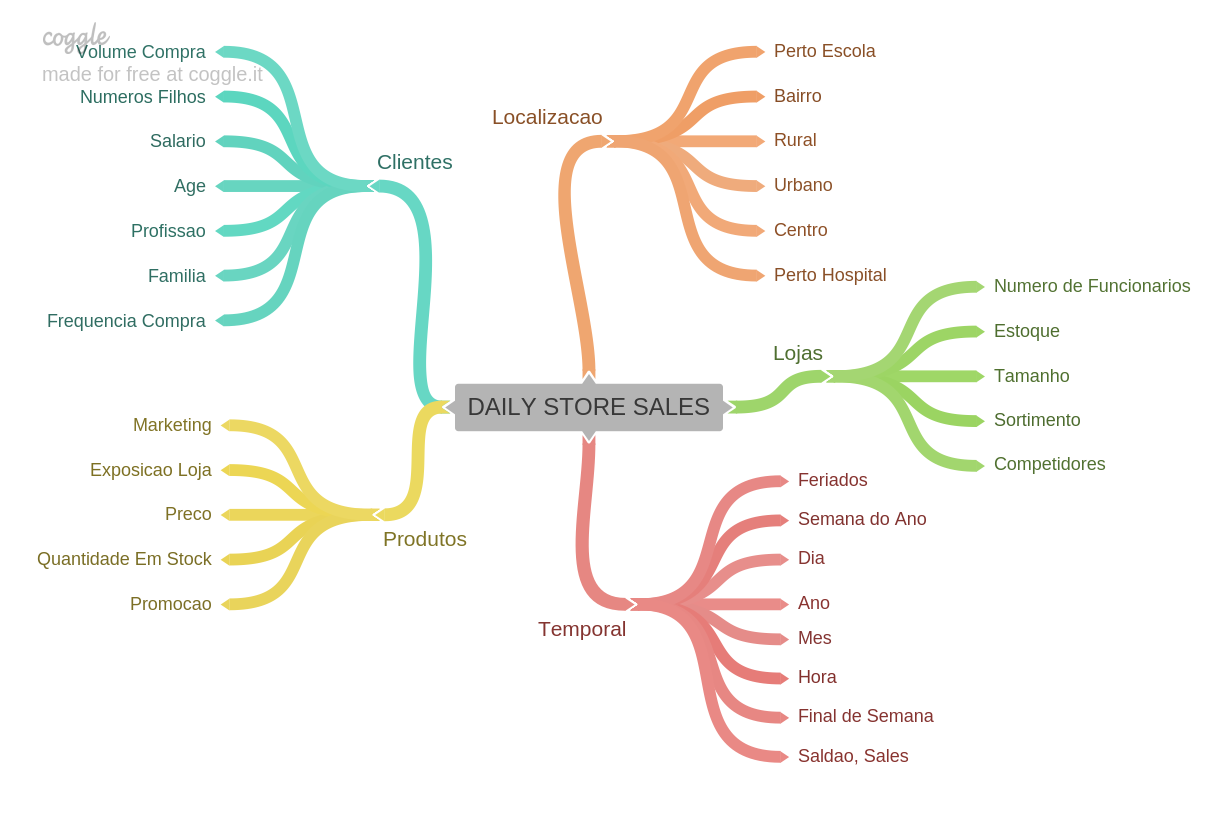

In [22]:
Image('img\MindMapHypothesis.png')

## 2.2. Criacao das Hipoteses


### 2.2.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais. 

**4.** Lojas com menor porte deveriam vender menos. 

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais.

### 2.2.3 Hipoteses tempo

**1.** Lojas que que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.3. Lista Final de Hipóteses

### Prioridade serão as hipósteses que já possuem dados para serem validadas

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com mais dias de promoção deveriam vender mais.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante feriados escolares.

## 2.4. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2[ 'competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w')- datetime.timedelta( days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda  x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda  x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [25]:
df2.head(4)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


In [26]:
df2.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
447328,999,2,2014-05-27,6834,531,1,0,regular_day,0,d,extended,15140.0,2,2002,1,37,2009,"Jan,Apr,Jul,Oct",May,0,2014,5,27,22,2014-21,2002-02-01,149,2009-09-07,246
95512,738,4,2015-05-07,9570,748,1,1,regular_day,0,d,extended,5980.0,10,2005,0,19,2015,,May,0,2015,5,7,19,2015-18,2005-10-01,116,2015-05-04,0
839202,393,7,2013-06-09,0,0,0,0,regular_day,0,d,extended,4820.0,3,2008,0,23,2013,,Jun,0,2013,6,9,23,2013-22,2008-03-01,64,2013-06-03,0
133232,548,5,2015-04-03,0,0,0,1,easter_holiday,1,d,extended,3760.0,2,2009,0,14,2015,,Apr,0,2015,4,3,14,2015-13,2009-02-01,75,2015-03-30,0
142693,1089,4,2015-03-26,7747,836,1,0,regular_day,0,d,basic,5220.0,5,2009,0,13,2015,,Mar,0,2015,3,26,13,2015-12,2009-05-01,71,2015-03-23,0
30036,1047,7,2015-07-05,0,0,0,0,regular_day,0,a,basic,3750.0,7,2015,1,45,2009,"Feb,May,Aug,Nov",Jul,0,2015,7,5,27,2015-26,2015-07-01,0,2009-11-02,295
397402,248,6,2014-07-12,7036,1023,1,0,regular_day,0,a,extended,340.0,9,2012,1,40,2012,"Jan,Apr,Jul,Oct",Jul,1,2014,7,12,28,2014-27,2012-09-01,22,2012-09-24,93
583955,481,5,2014-01-24,5442,496,1,1,regular_day,0,c,extended,7470.0,1,2014,1,44,2012,"Feb,May,Aug,Nov",Jan,0,2014,1,24,4,2014-03,2014-01-01,0,2012-10-22,65
240809,829,6,2014-12-27,5028,778,1,0,regular_day,1,c,basic,110.0,12,2014,0,52,2014,,Dec,0,2014,12,27,52,2014-51,2014-12-01,0,2014-12-22,0
763557,568,5,2013-08-16,5360,443,1,1,regular_day,1,d,extended,4270.0,8,2013,1,1,2013,"Jan,Apr,Jul,Oct",Aug,0,2013,8,16,33,2013-32,2013-08-01,0,2012-12-31,32


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [29]:
df3.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
226184,955,6,2015-01-10,4360,434,1,0,regular_day,0,d,extended,1690.0,7,2009,1,36,2013,"Mar,Jun,Sept,Dec",Jan,0,2015,1,10,2,2015-01,2009-07-01,67,2013-09-02,70
526830,221,7,2014-03-16,0,0,0,0,regular_day,0,d,extended,13530.0,9,2013,0,11,2014,,Mar,0,2014,3,16,11,2014-10,2013-09-01,6,2014-03-10,0
387051,169,3,2014-07-23,16233,948,1,0,regular_day,1,d,basic,980.0,7,2014,1,18,2014,"Feb,May,Aug,Nov",Jul,0,2014,7,23,30,2014-29,2014-07-01,0,2014-04-28,12
180234,720,5,2015-02-20,7005,676,1,1,regular_day,0,a,extended,15320.0,3,2011,1,14,2013,"Feb,May,Aug,Nov",Feb,1,2015,2,20,8,2015-07,2011-03-01,48,2013-04-01,98
137937,793,1,2015-03-30,10359,746,1,1,regular_day,1,d,basic,2710.0,7,2006,0,14,2015,,Mar,0,2015,3,30,14,2015-13,2006-07-01,106,2015-03-30,0
603281,852,2,2014-01-07,6337,689,1,1,regular_day,1,c,basic,940.0,4,2004,1,14,2011,"Jan,Apr,Jul,Oct",Jan,1,2014,1,7,2,2014-01,2004-04-01,118,2011-03-28,145
496178,789,7,2014-04-13,0,0,0,0,regular_day,0,a,extended,9770.0,7,2003,0,15,2014,,Apr,0,2014,4,13,15,2014-14,2003-07-01,131,2014-04-07,0
581218,1089,1,2014-01-27,7059,807,1,0,regular_day,0,d,basic,5220.0,5,2009,0,5,2014,,Jan,0,2014,1,27,5,2014-04,2009-05-01,57,2014-01-27,0
574601,47,6,2014-02-01,5484,704,1,0,regular_day,0,a,extended,270.0,4,2013,1,14,2013,"Jan,Apr,Jul,Oct",Feb,0,2014,2,1,5,2014-04,2013-04-01,10,2013-04-01,43
944352,733,4,2013-03-07,14201,3351,1,1,regular_day,0,b,extra,860.0,10,1999,0,10,2013,,Mar,0,2013,3,7,10,2013-09,1999-10-01,163,2013-03-04,0


## 3.1. Filtragem das Linhas

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [32]:
df3.sample(10)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
443866,882,5,2014-05-30,8009,0,regular_day,0,a,basic,30.0,4,2013,0,22,2014,0,2014,5,30,22,2014-21,2013-04-01,14,2014-05-26,0
294473,152,4,2014-10-30,5541,0,regular_day,0,a,basic,1780.0,10,2014,0,44,2014,0,2014,10,30,44,2014-43,2014-10-01,0,2014-10-27,0
599795,711,5,2014-01-10,10915,1,regular_day,0,d,basic,17110.0,3,2007,1,5,2010,1,2014,1,10,2,2014-01,2007-03-01,83,2010-01-25,206
142564,960,4,2015-03-26,5560,0,regular_day,0,d,basic,8990.0,3,2015,1,31,2009,0,2015,3,26,13,2015-12,2015-03-01,0,2009-07-27,295
194076,67,6,2015-02-07,5586,0,regular_day,0,a,extended,410.0,2,2006,0,6,2015,0,2015,2,7,6,2015-05,2006-02-01,109,2015-02-02,0
650999,625,1,2013-11-25,5919,0,regular_day,0,a,basic,1170.0,4,2011,1,22,2012,1,2013,11,25,48,2013-47,2011-04-01,32,2012-05-21,79
378947,533,5,2014-08-01,11161,1,regular_day,1,a,extended,5950.0,8,2014,0,31,2014,0,2014,8,1,31,2014-30,2014-08-01,0,2014-07-28,0
991430,981,4,2013-01-24,6850,1,regular_day,0,d,extended,2620.0,11,2002,0,4,2013,0,2013,1,24,4,2013-03,2002-11-01,124,2013-01-21,0
136545,516,2,2015-03-31,8625,1,regular_day,1,a,extended,20.0,3,2015,1,35,2010,1,2015,3,31,14,2015-13,2015-03-01,1,2010-08-23,240
156000,1016,6,2015-03-14,4479,0,regular_day,0,c,extended,550.0,3,2015,1,35,2010,1,2015,3,14,11,2015-10,2015-03-01,0,2010-08-23,237


# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [33]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

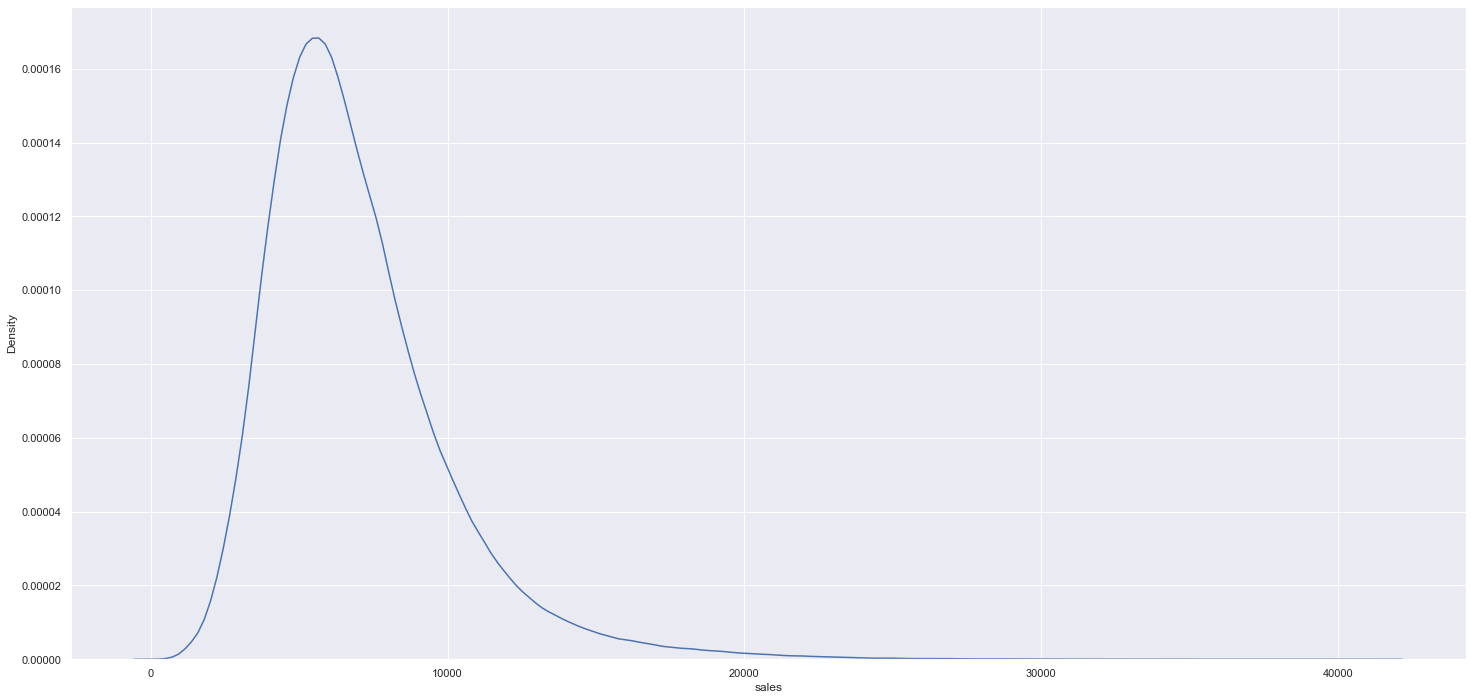

In [34]:
sns.kdeplot( data=df4, x='sales')

### 4.1.2. Numerical Variable


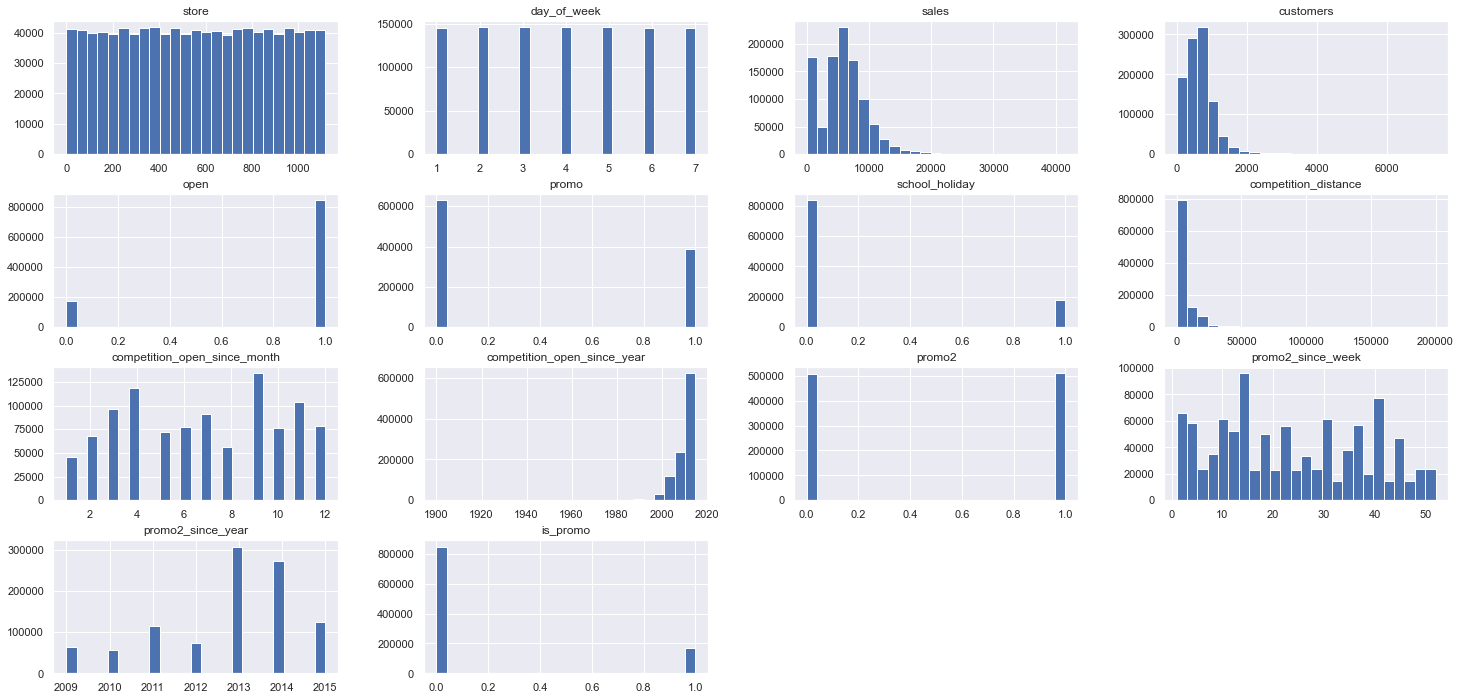

In [35]:
num_attributes.hist( bins=25);

### 4.1.3. Categorical Variable

In [36]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,,Jul
4,0,a,a,,Jul


In [37]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [38]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [39]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [40]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

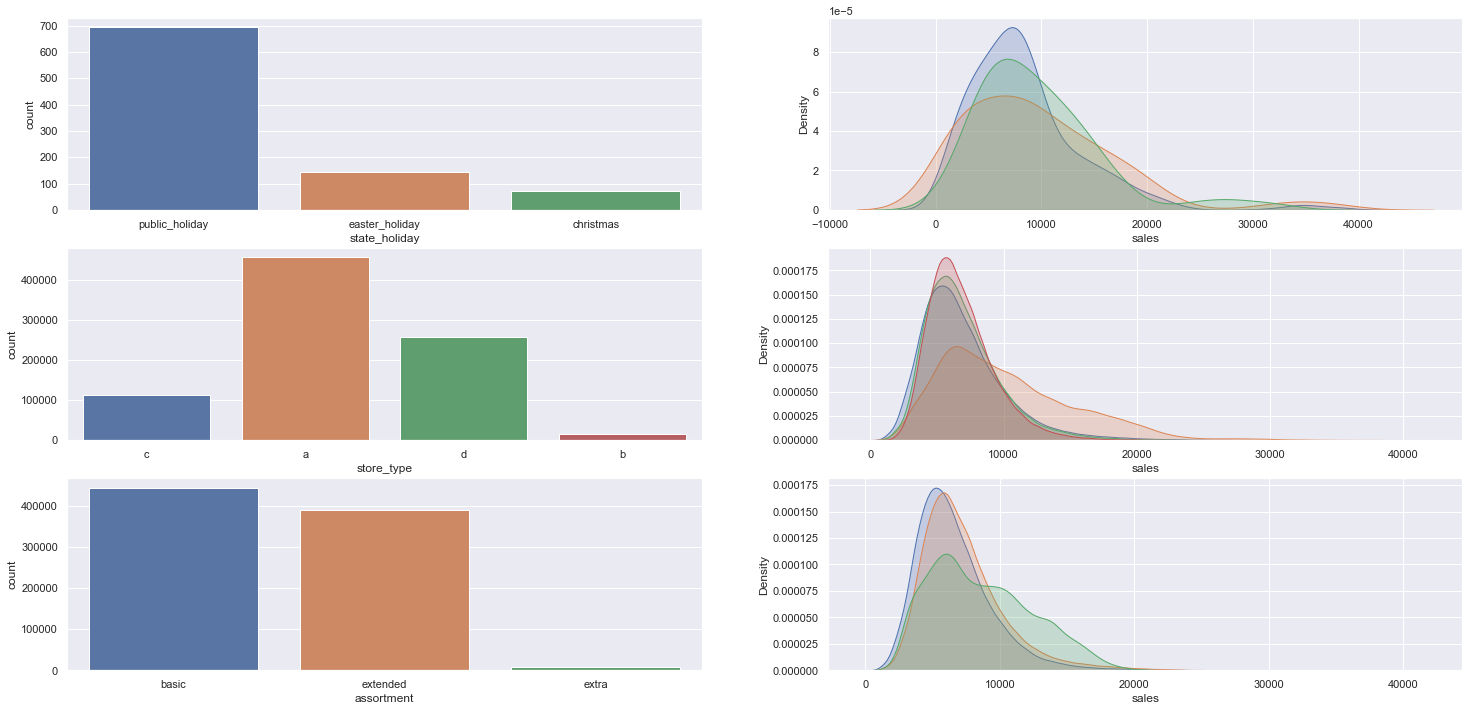

In [41]:
# state_holiday
plt.subplot(3,2,1)
dfa = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( data= dfa, x=dfa['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot(3,2,3)
sns.countplot( data = df4, x=df4['store_type'])
                 
plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
                
# assortment
plt.subplot(3,2,5)
sns.countplot( data = df4, x=df4['assortment'])
                 
plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

                 
                 
                 

## 4.2. Analise Bivariada

### 4.2.1. Resumo das Hipoteses

In [42]:
tab =[['Hipoteses', 'Conclusão', 'Relevancia'],
     ['H1', 'Falsa','Baixa'],
     ['H2', 'Falsa','Media'],
     ['H3', 'Falsa','Media'],      
     ['H4', 'Falsa','Baixa'],      
     ['H5', '-','-'],      
     ['H6', 'Falsa','Baixa'],      
     ['H7', 'Falsa','Media'],      
     ['H8', 'Falsa','Alta'],      
     ['H9', 'Falsa','Alta'],      
     ['H10', 'Verdadeira','Alta'],      
     ['H11', 'Verdadeira','Alta'],      
     ['H12', 'Verdadeira','Baixa'],
     ]
print( tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.
**Gera Insight** por ser contra intuitivo

<AxesSubplot:xlabel='assortment', ylabel='sales'>

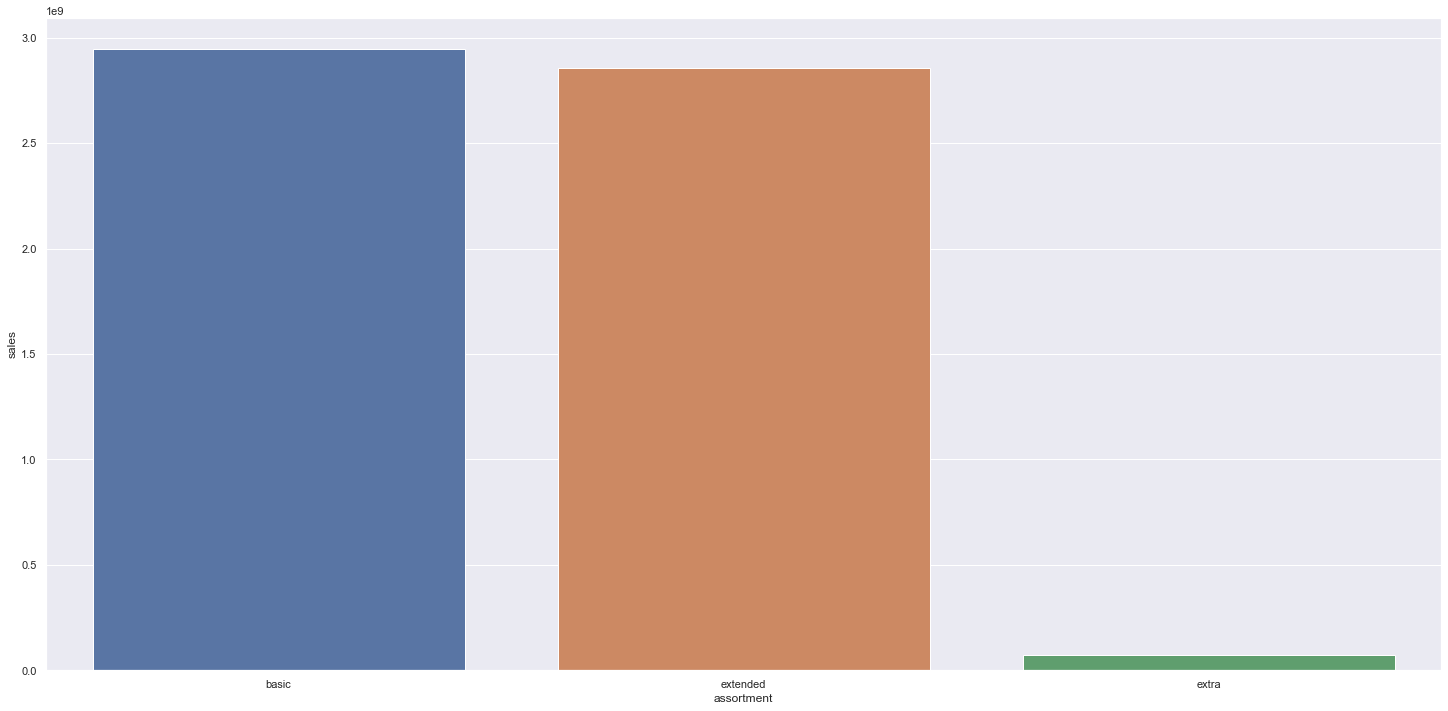

In [43]:
aux1 =df4[['assortment', 'sales']].groupby( 'assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1)

#### Insight - Assumindo que o Assortment Extra é oque possui maior sortimento, assumimos que a hipótese é falsa, tendo em vista que pelos dados apresentado, é oque possui menor quantidade de vendas.

<AxesSubplot:xlabel='year_week'>

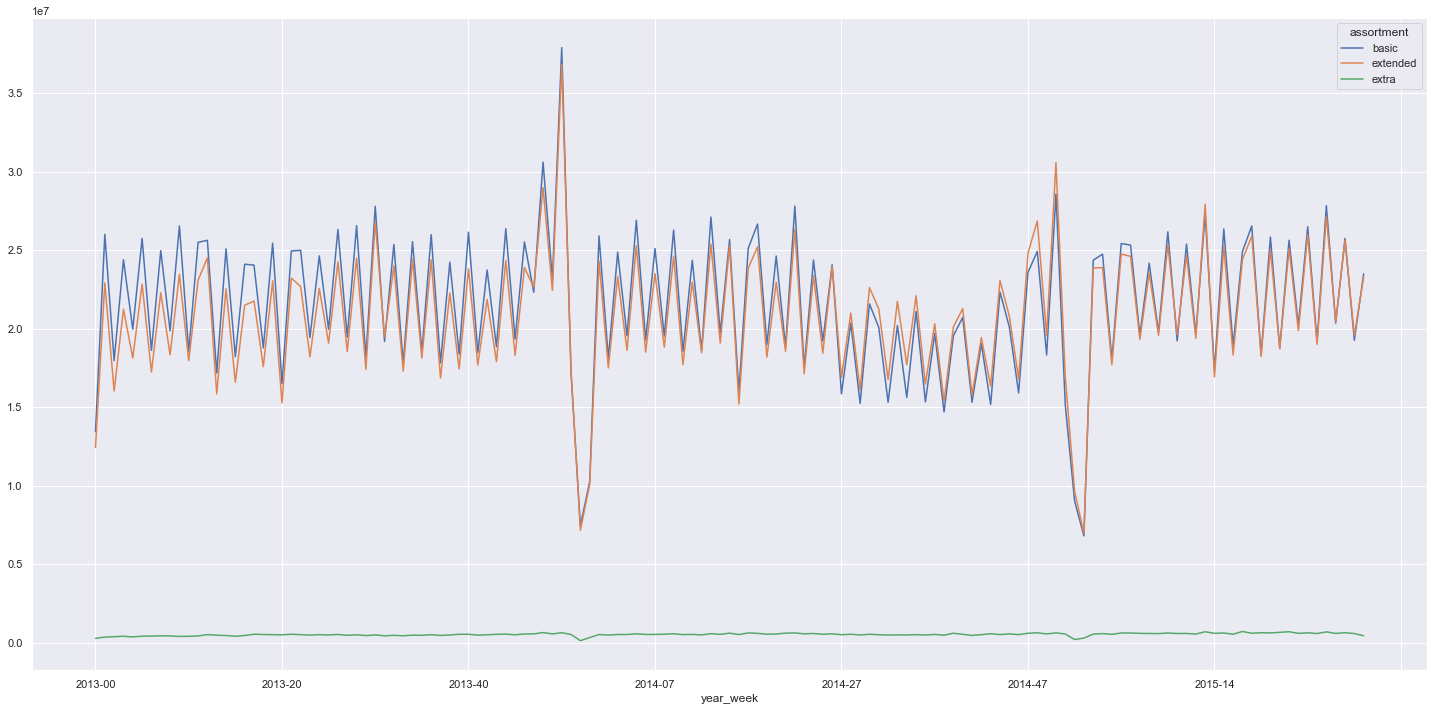

In [44]:
aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment',values='sales').plot()

#### Basic e Extended, possuem o mesmo comportamento ao longo do tempo, o Extra fica muito pequena nessa análise, necessário ver se comportamento sozinha

<AxesSubplot:xlabel='year_week'>

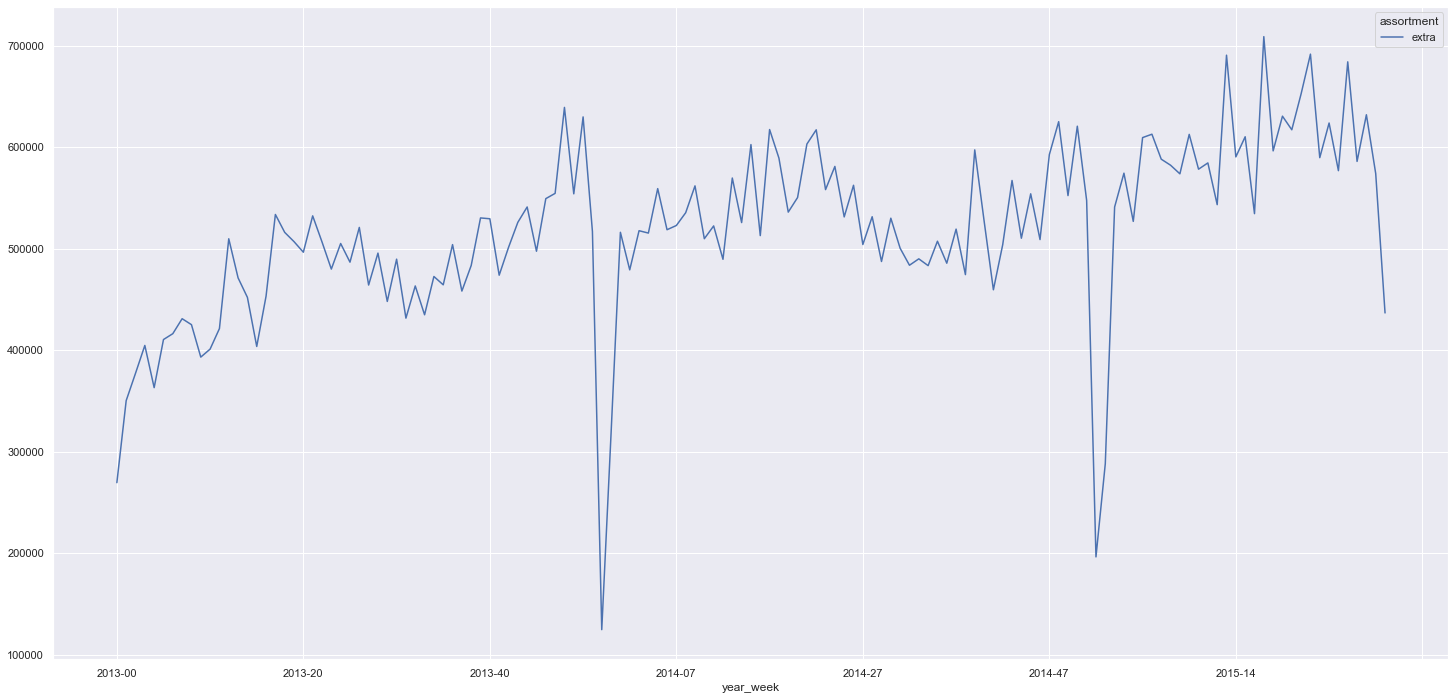

In [45]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment',values='sales').plot()

#### Interessante ver como que com uma escola diferente se observa uma variancia maior de vendas ao longo do tempo.

### H2. Lojas com mais dias de promoção deveriam vender mais.
**FALSA** Lojas com compedidores mais próximos vendem mais.**Gera Insight** por ser contra intuitivo

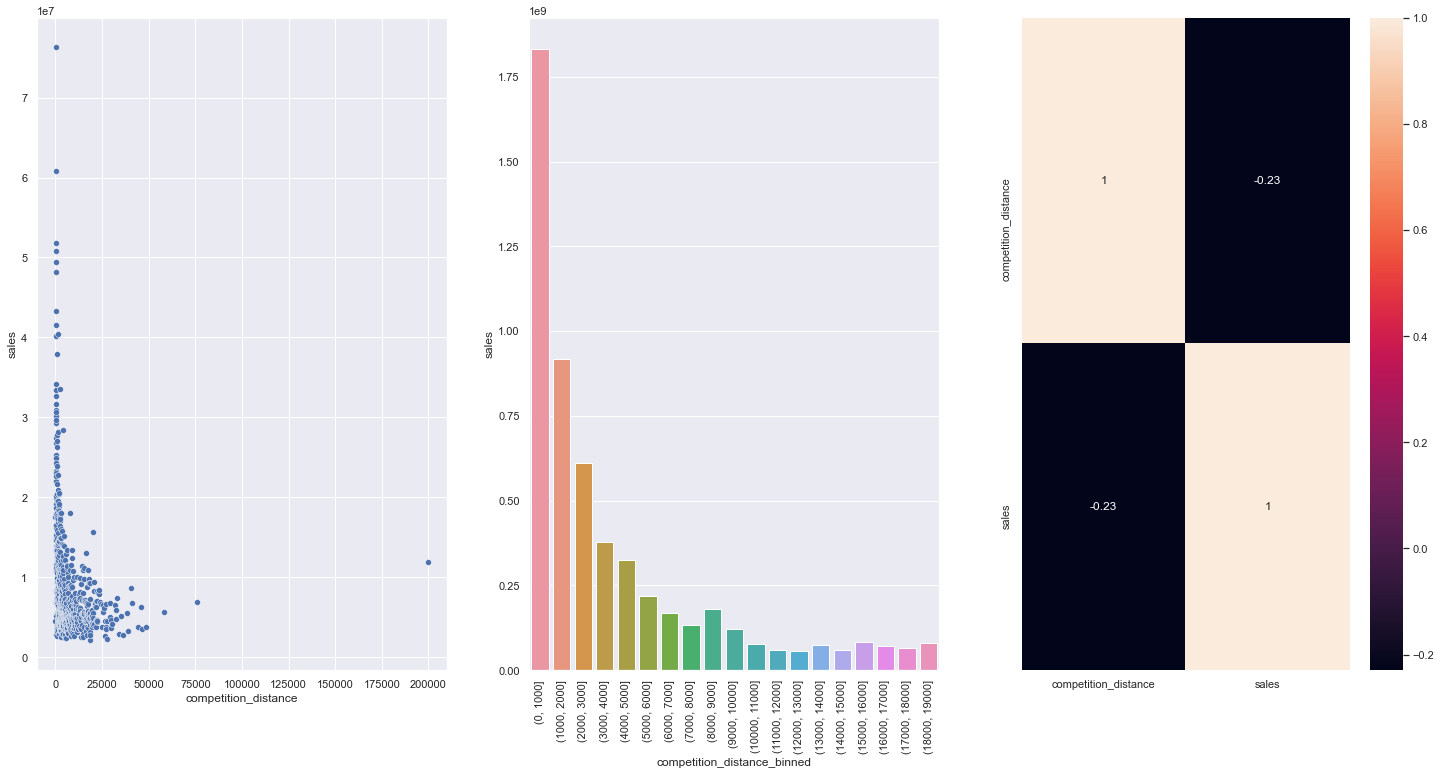

In [46]:
aux4 = df4[['competition_distance', 'sales']].groupby( 'competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot( x ='competition_distance', y='sales', data=aux4);

plt.subplot(1,3,2)
bins = list( np.arange(0, 20000, 1000))
aux4['competition_distance_binned'] = pd.cut( aux4['competition_distance'],bins=bins)
aux5 = aux4[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux5);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap( aux4.corr( method='pearson'), annot=True);


#### Insight - Possível verificar que competidores mais próximos as lojas vendem mais do que com a distância maior.

### H3. Lojas com competidores à mais tempo deveriam vender mais.
**FALSO** quanto mais recente a competição, maior é a quantidade de vendas.

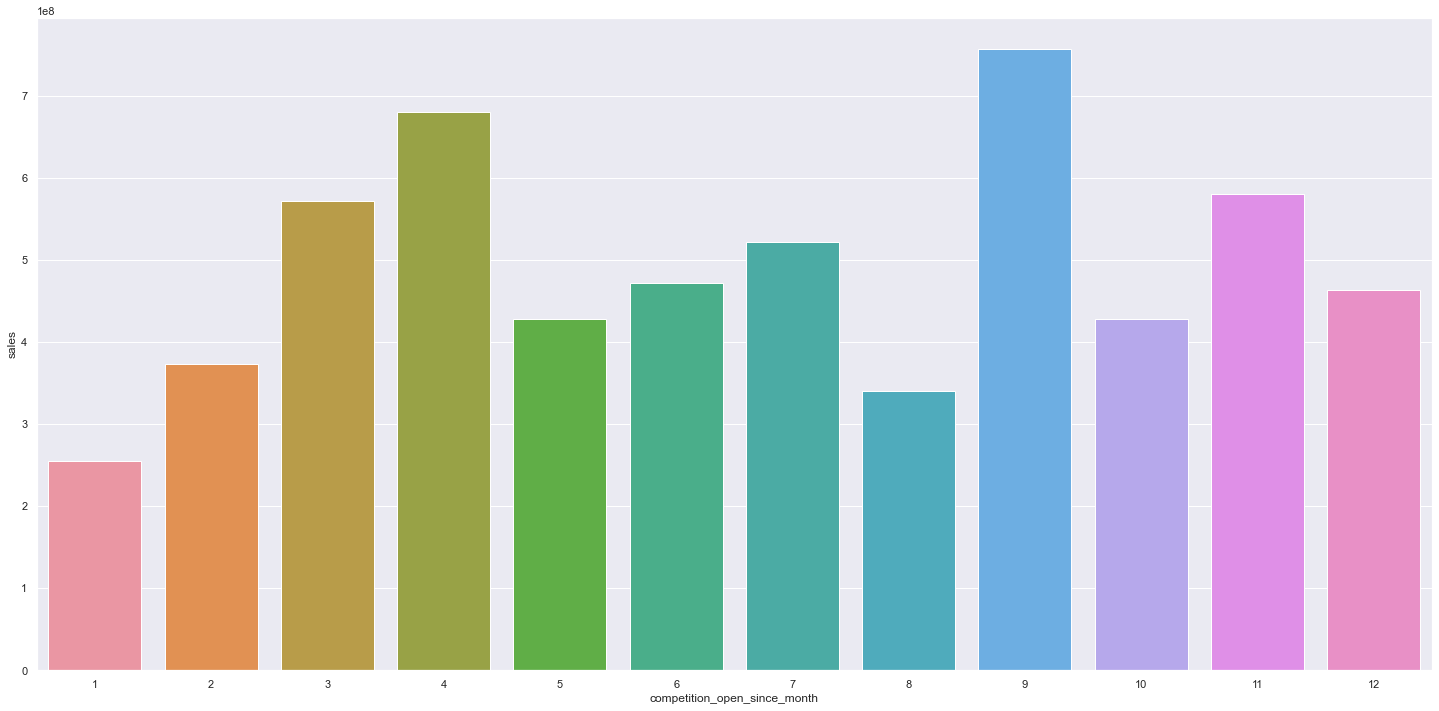

In [47]:
aux6 = df4[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month').sum().reset_index()
sns.barplot( x = 'competition_open_since_month', y ='sales', data=aux6);

#### Necessário realizar uma correlação melhor entre o inicio da competição é a quantidade de vendas.

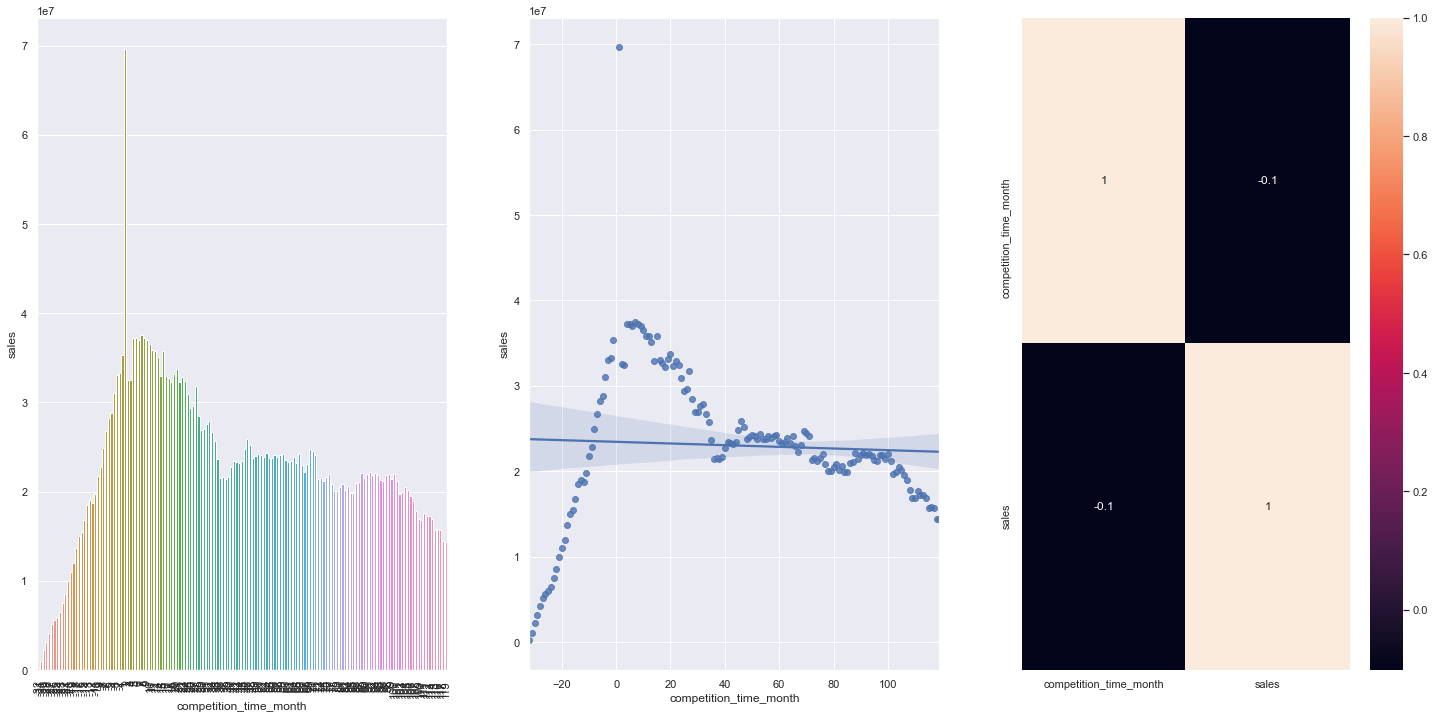

In [48]:
plt.subplot( 1,3,1)
aux7 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month').sum().reset_index()
aux8 = aux7[(aux7['competition_time_month'] < 120 ) & (aux7['competition_time_month'] != 0)]
sns.barplot( x = 'competition_time_month', y ='sales', data=aux8);
plt.xticks( rotation= 90);

plt.subplot( 1,3,2)
sns.regplot( x = 'competition_time_month', y ='sales', data=aux8);

plt.subplot( 1,3,3)
sns.heatmap( aux7.corr( method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção.

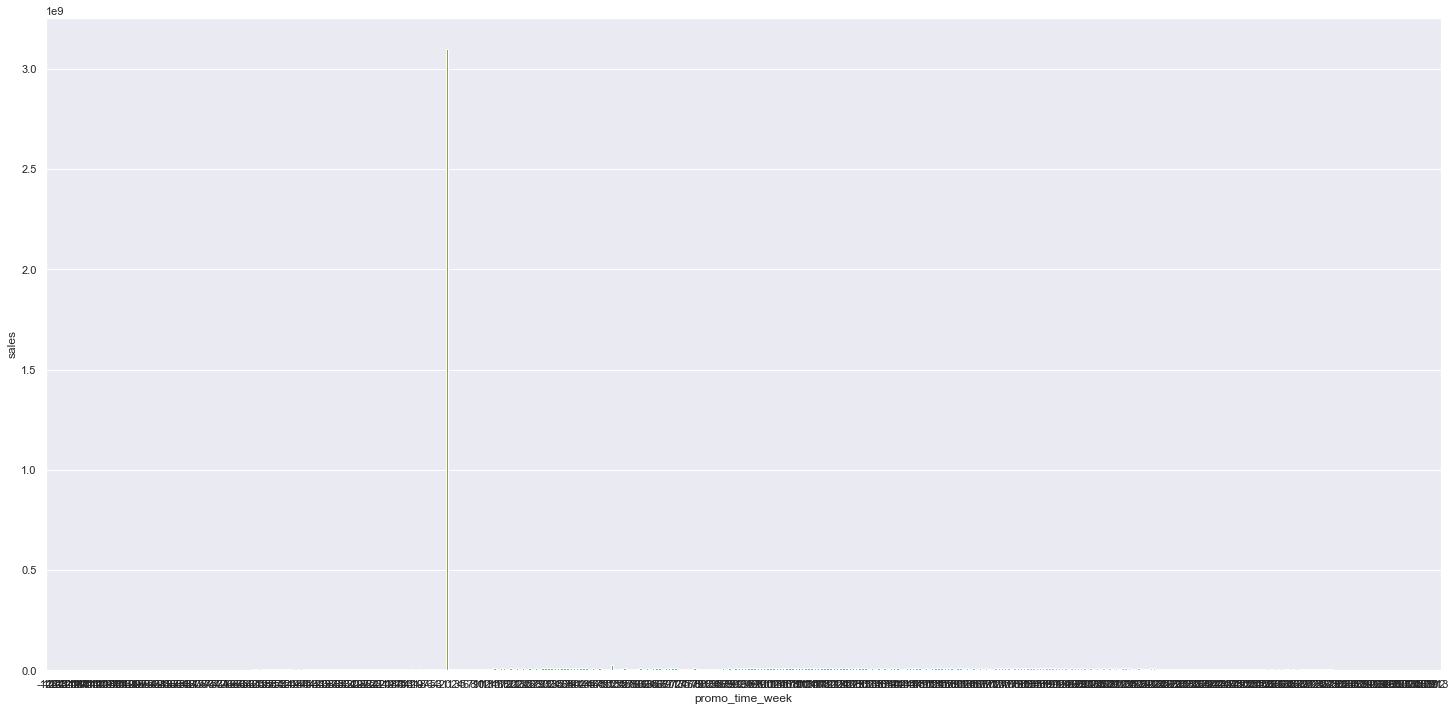

In [49]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot( x='promo_time_week', y='sales', data=aux1);

#### Como há uma grande quantidade de dados, é necessário realizar um recorte. Feito para que seja possível visualizar os dados.

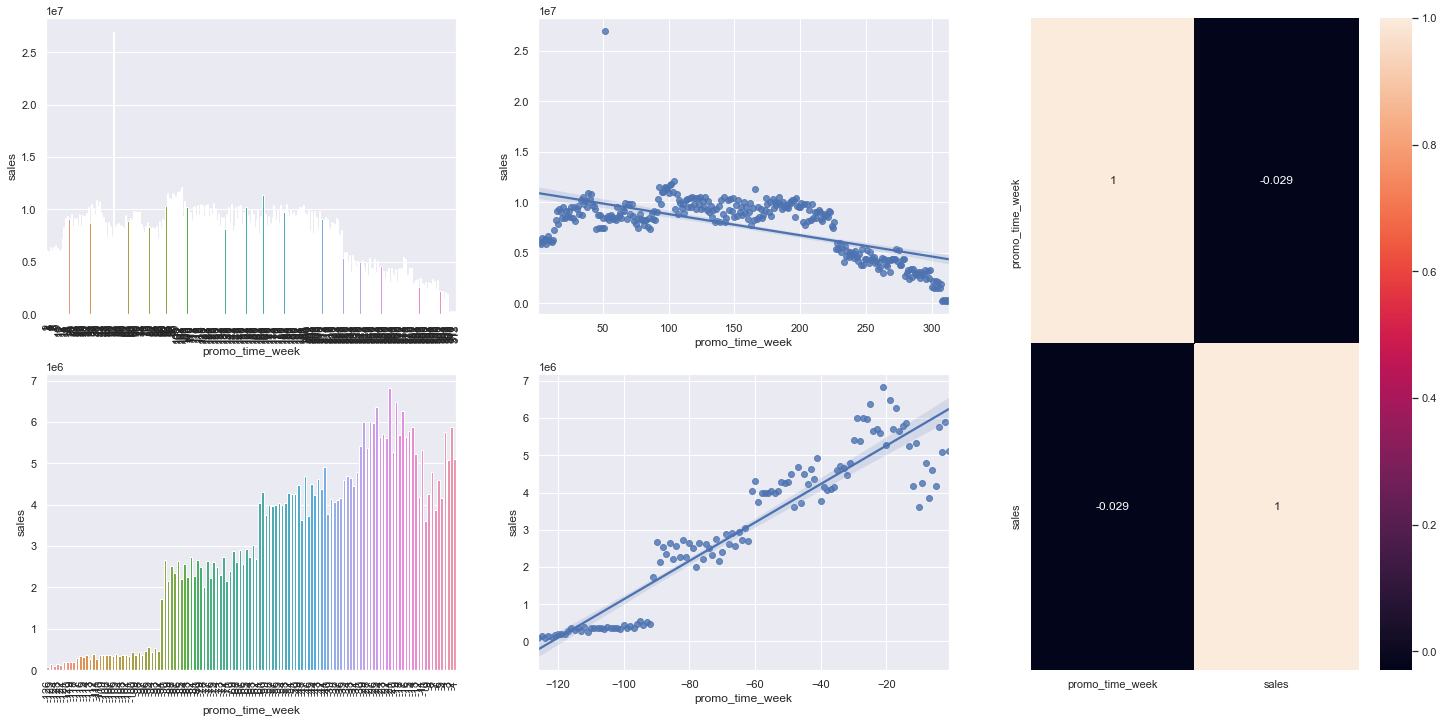

In [50]:
grid = GridSpec(2,3)
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot( x ='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x ='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot( x ='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x ='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'),annot=True);


### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções concecutivas vendem menos.

**SERA VALIDADA NO PRÓXIMO CICLO DO CRISP**

In [51]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


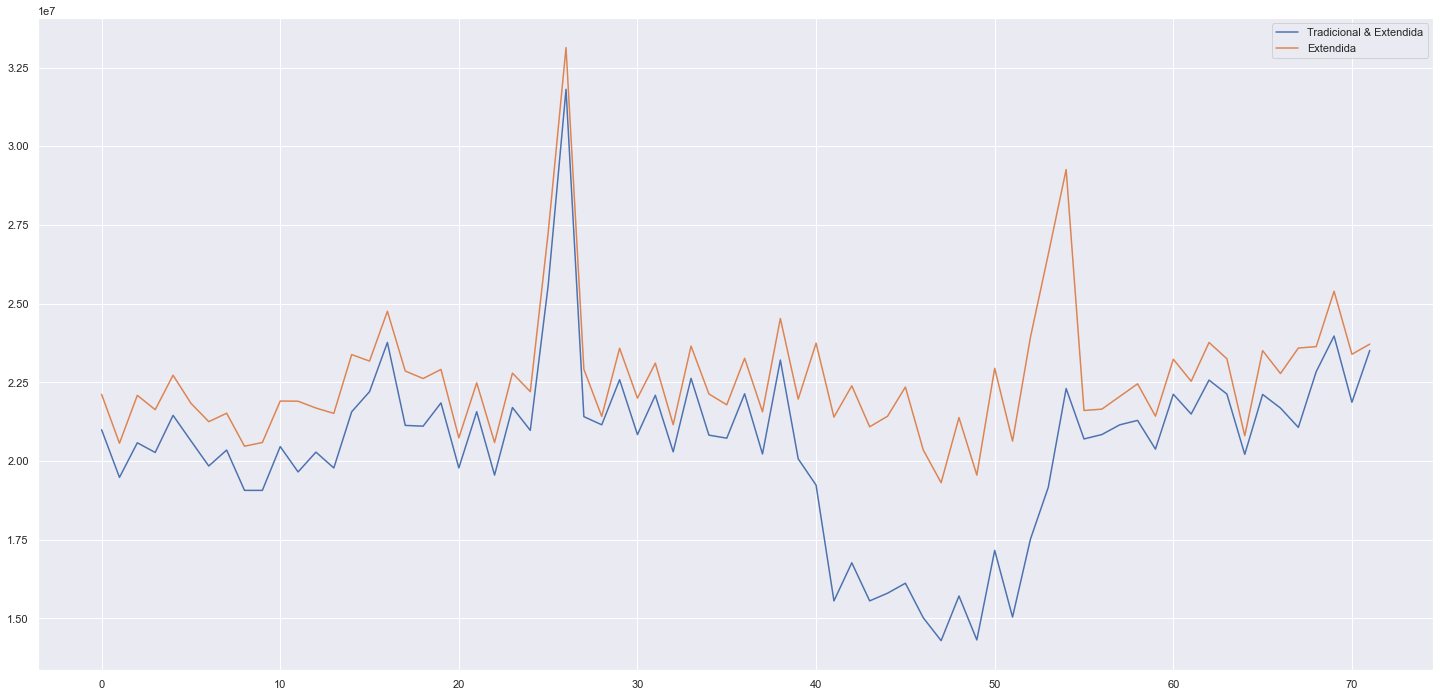

In [52]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax= ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### Quanto mais recente, próximo de 0, maior é a quantidade de vendas.

### H7. Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSO** Lojas abertas no natal vendem menos

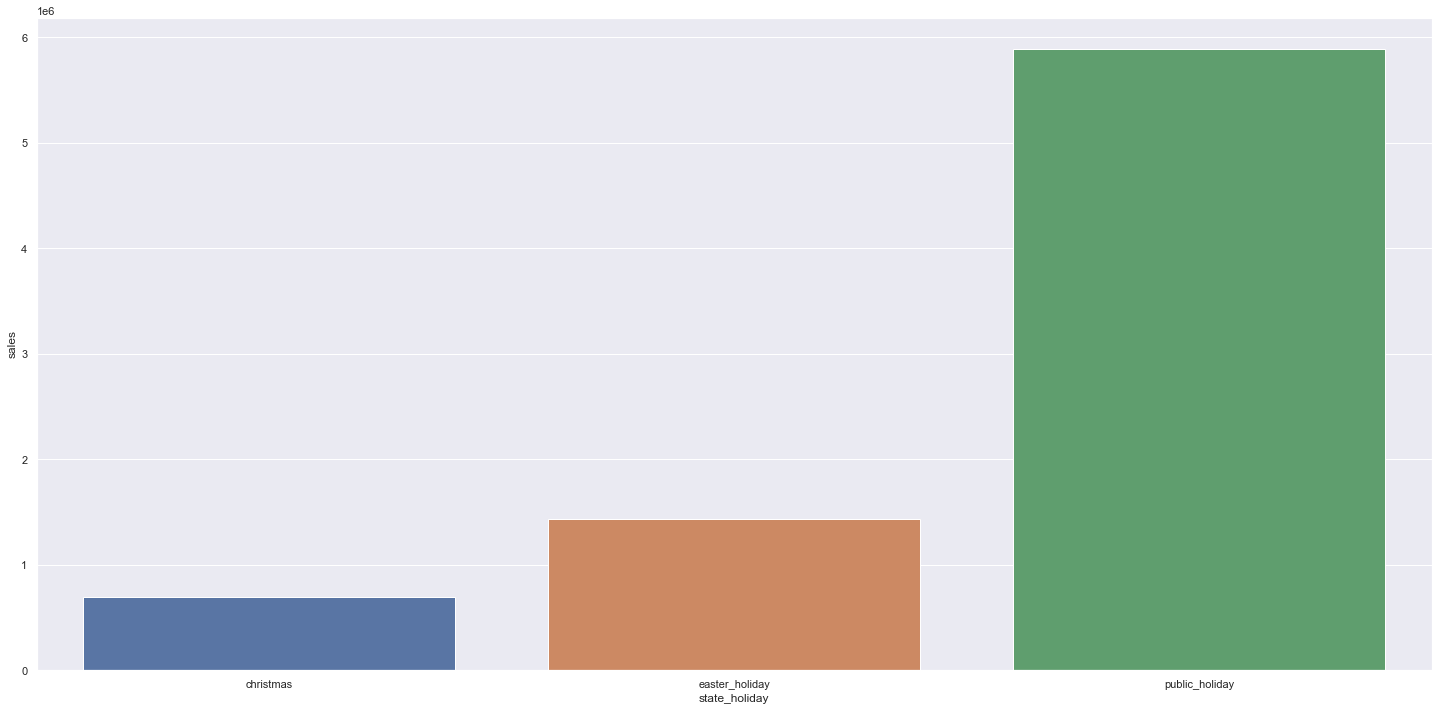

In [53]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y='sales', data=aux1);

#### Nota-se que no natal se vendeu menos que o restante das datas. Para verificar se isso ocorreu em todos os anos vou dividir os dados por ano 

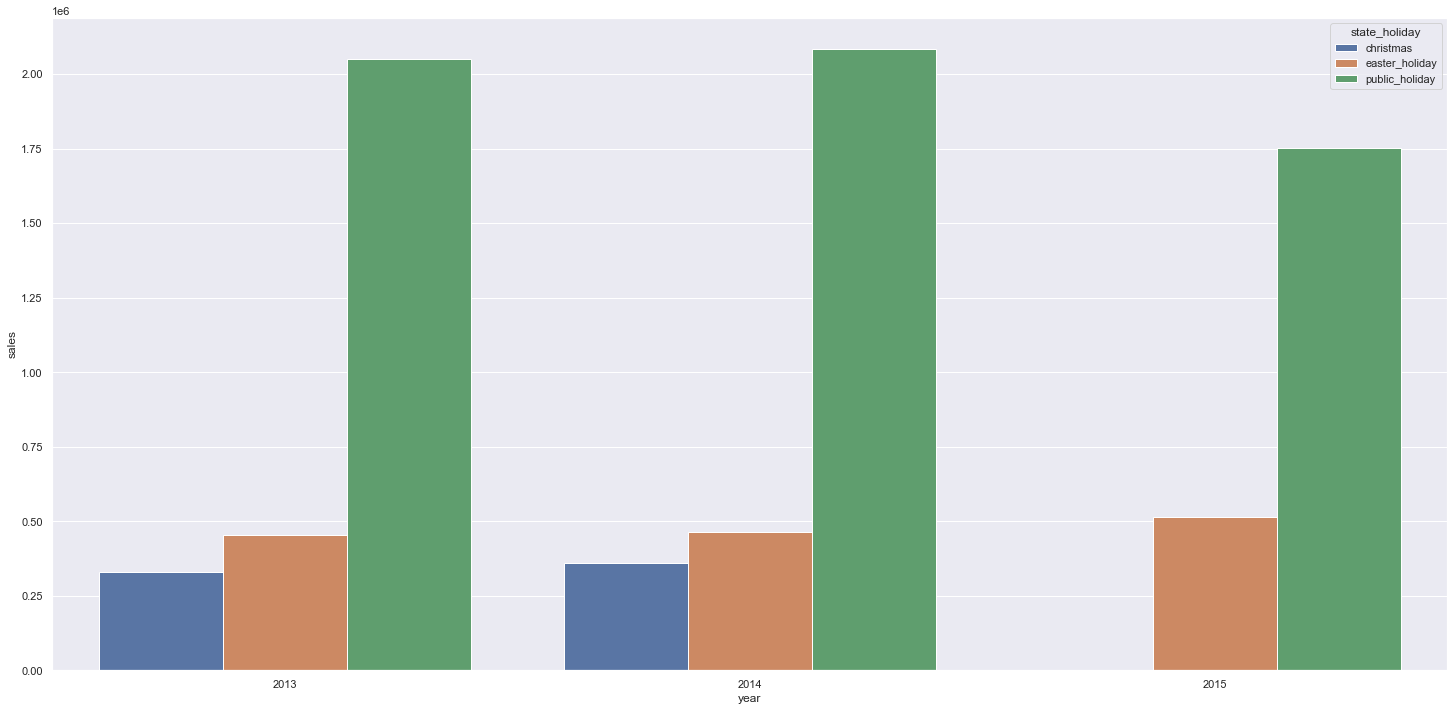

In [54]:
aux2 = aux[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y='sales',hue = 'state_holiday', data=aux2);


### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSO** Vendem Menos 

<AxesSubplot:>

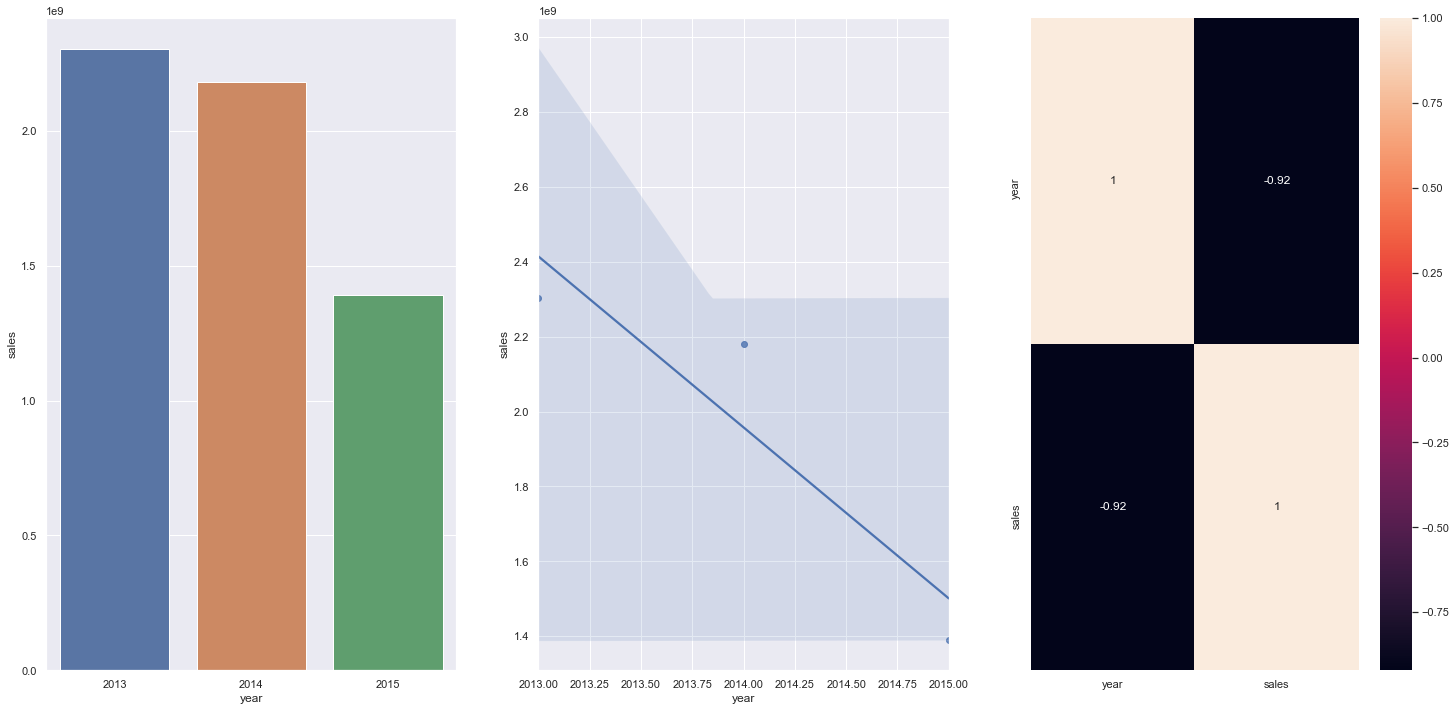

In [55]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'),annot=True)

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** vendem menos no segundo semestre

<AxesSubplot:>

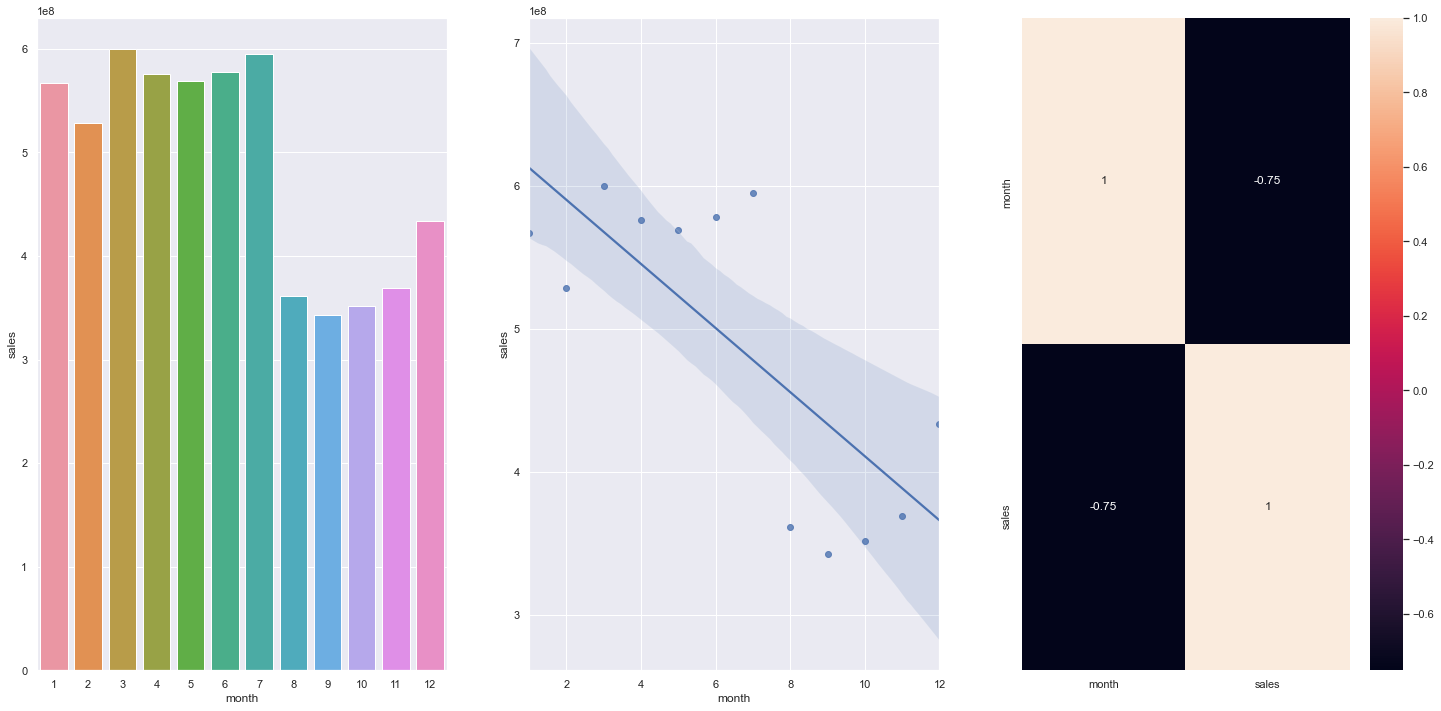

In [56]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'),annot=True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** lojas vendem mais depois do dia 10

In [57]:
aux1.head()

,month,sales
0,1,566728724
1,2,528734410
2,3,599831906
3,4,575895295
4,5,569248217


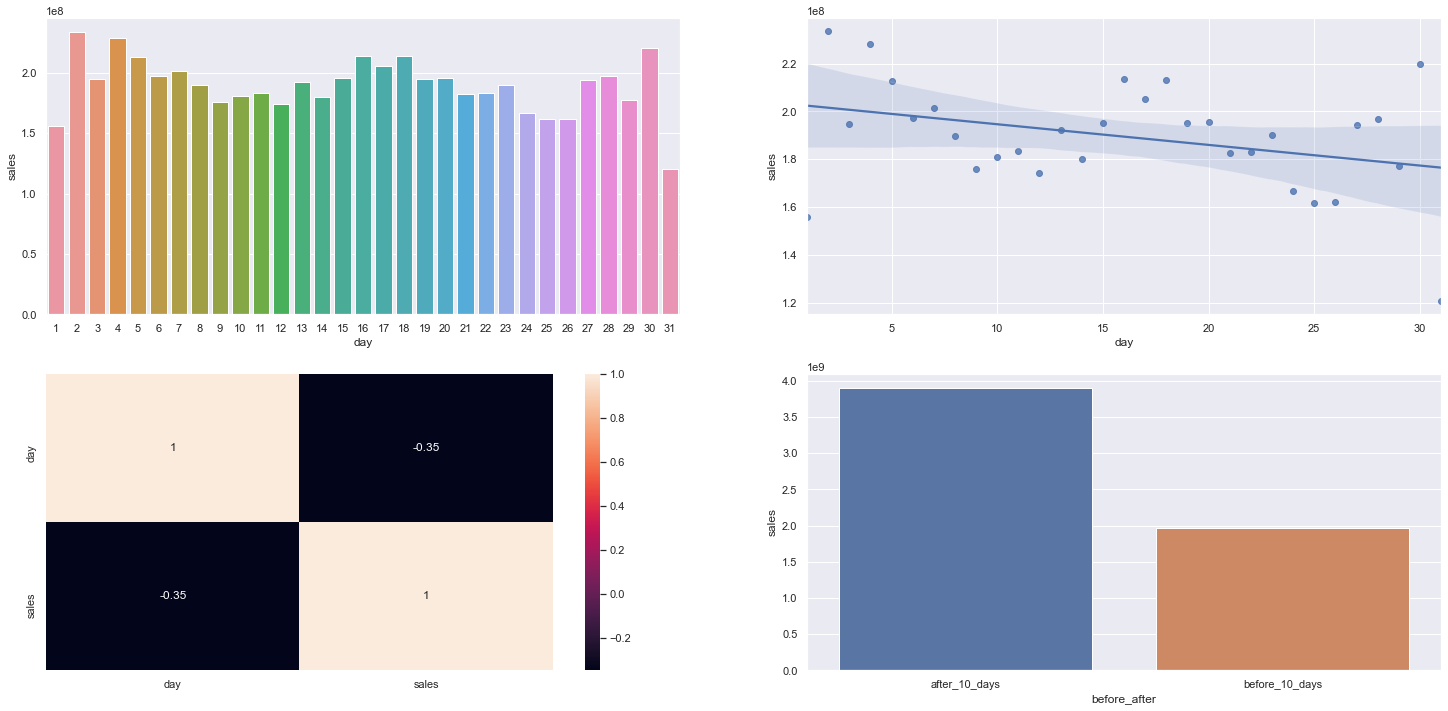

In [58]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr( method='pearson'),annot=True)


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** porque lojas vendem menos nos finais de semana

<AxesSubplot:>

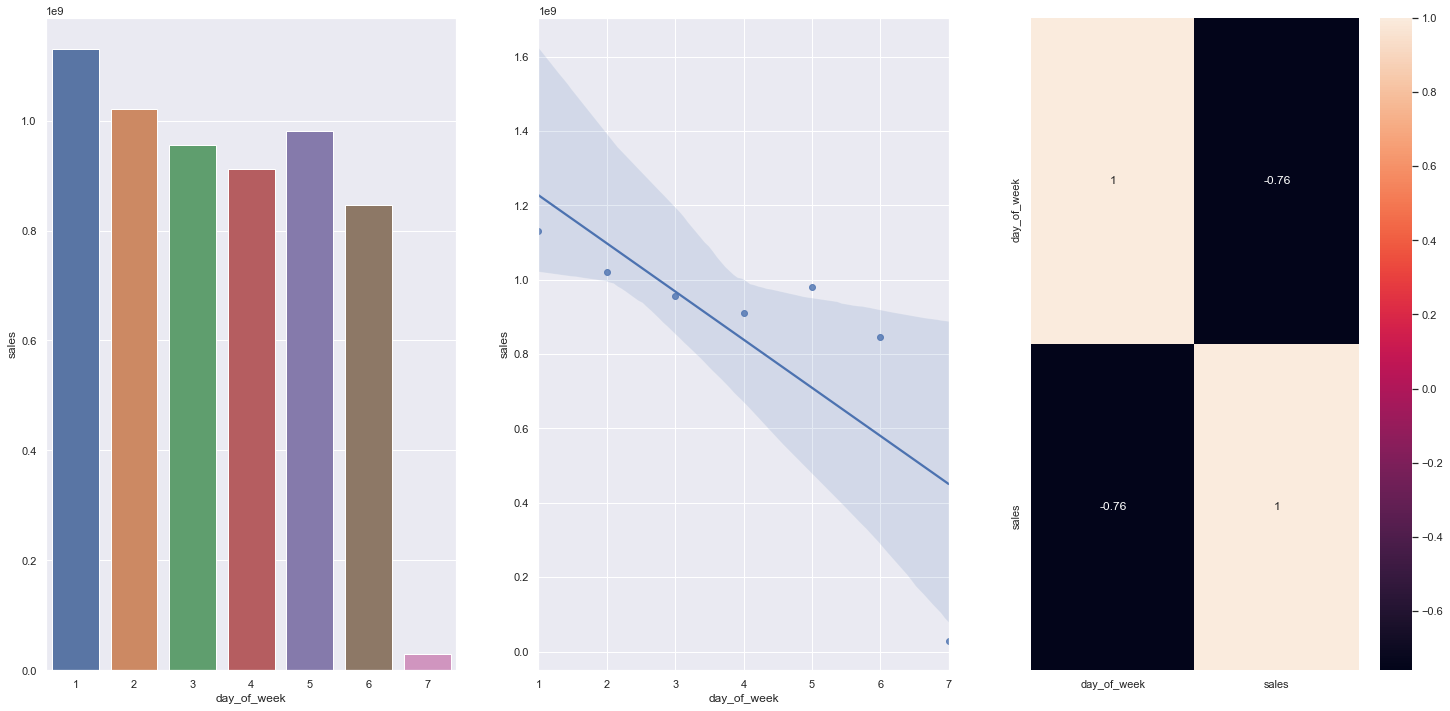

In [59]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'),annot=True)



### H12. Lojas deveriam vender menos durante feriados escolares.
**VERDADEIRA** porque lojas vendem menos durantes os feriados escolares, exceto o mês de Agosto.

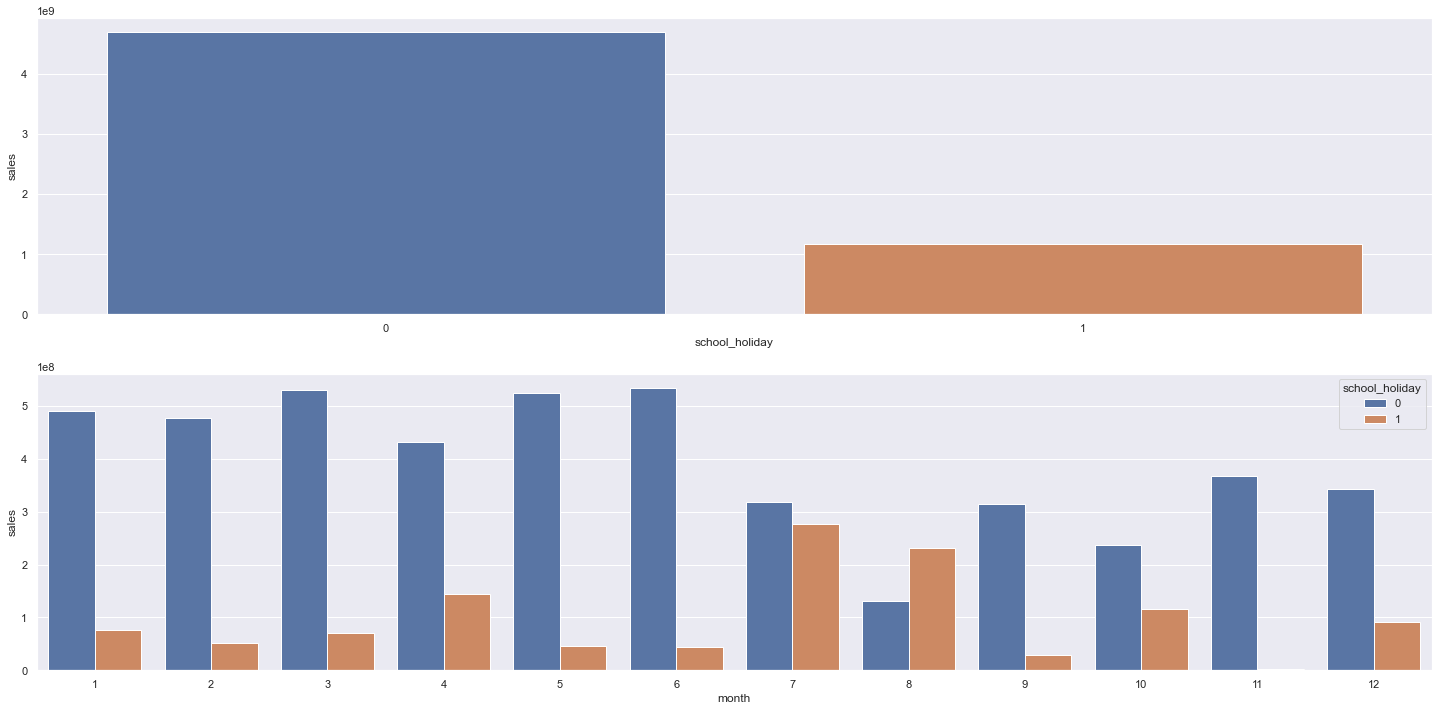

In [60]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2); 

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

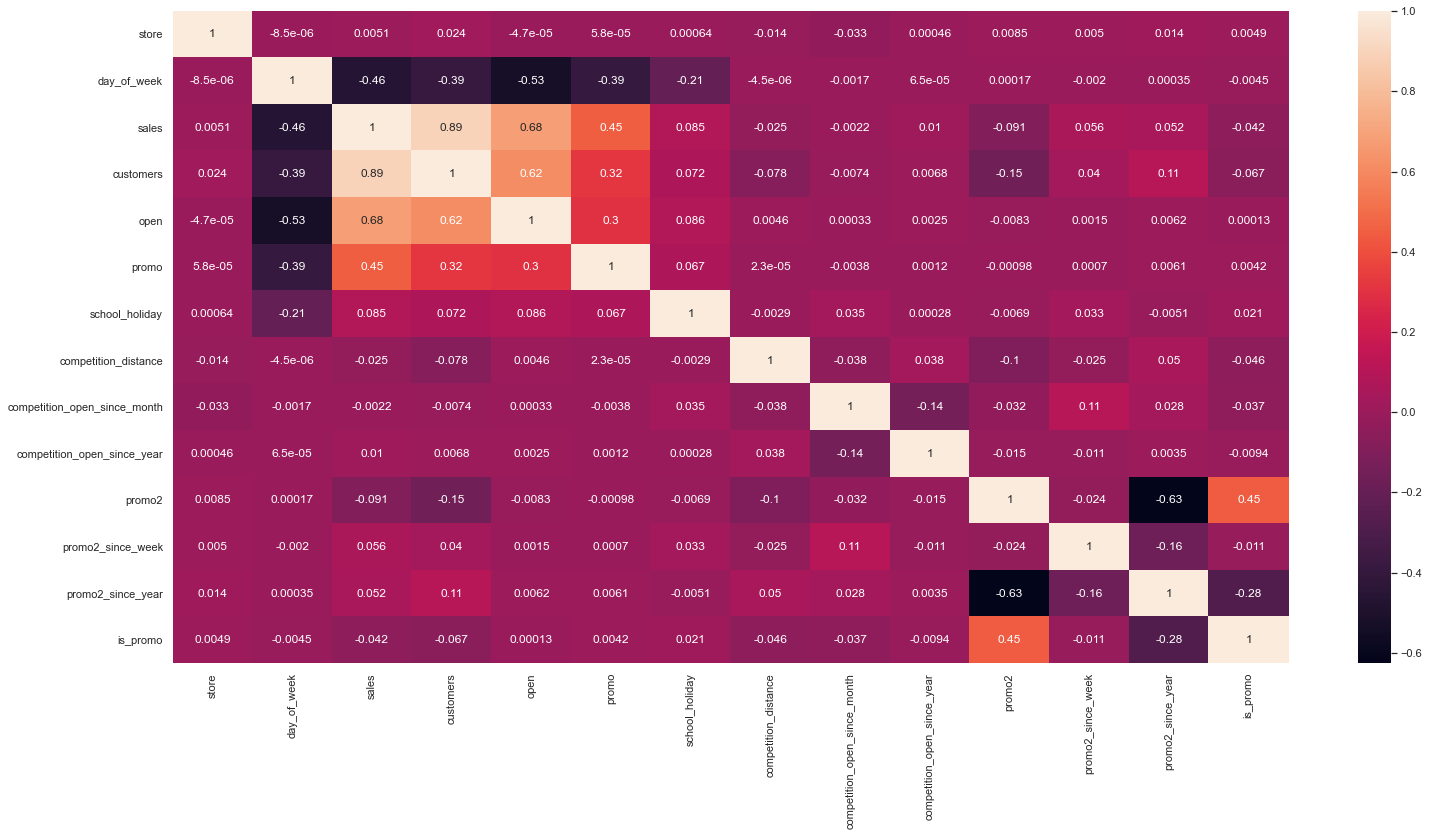

In [61]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2. Categorical Attributes

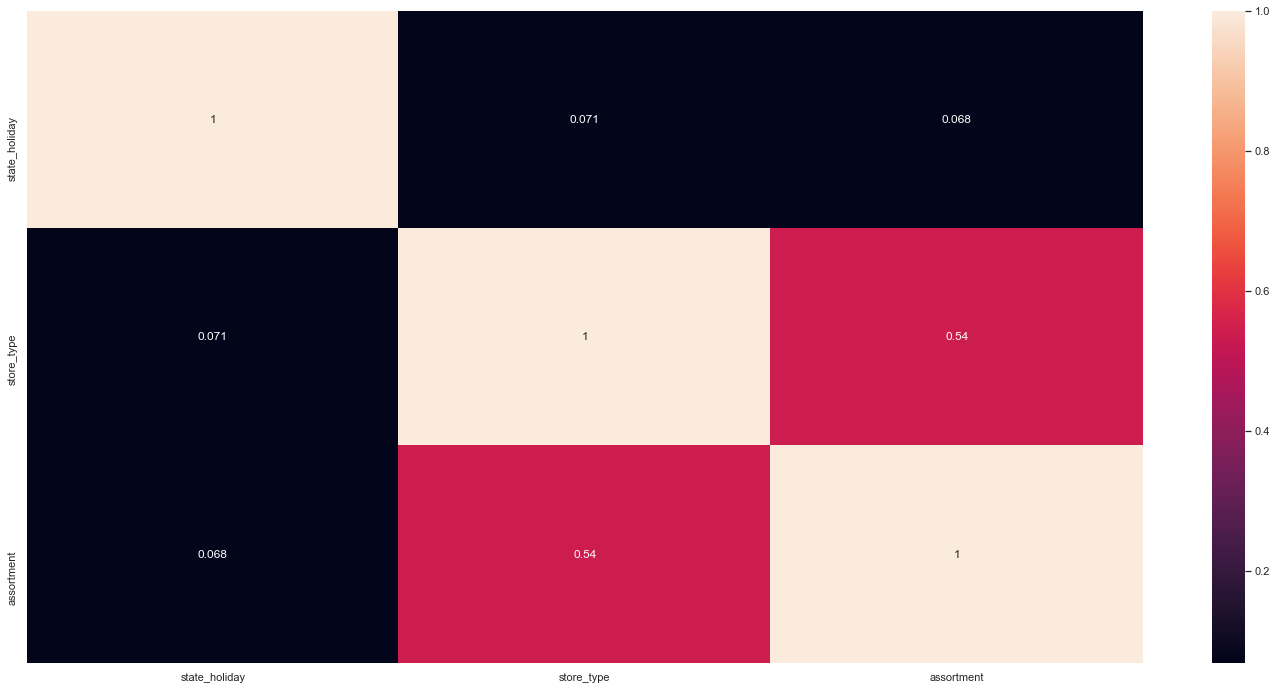

In [62]:
#somente atributos categoricos
a = df4.select_dtypes( include='object')

#calculando cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'] )
a2 = cramer_v(a['state_holiday'], a['store_type'] )
a3 = cramer_v(a['state_holiday'], a['assortment'] )

a4 = cramer_v(a['store_type'], a['state_holiday'] )
a5 = cramer_v(a['store_type'], a['store_type'] )
a6 = cramer_v(a['store_type'], a['assortment'] )

a7 = cramer_v(a['assortment'], a['state_holiday'] )
a8 = cramer_v(a['assortment'], a['store_type'] )
a9 = cramer_v(a['assortment'], a['assortment'] )

#dataset final
d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})
d = d.set_index(d.columns)

#mapa de calor 
sns.heatmap(d,annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [183]:
df5 = df4.copy()

## 5.1. Normalizacao

**Como não há nenhuma varíavel numérica com formato de Normal, é aconselhavel não forçar a Normalização e trabalhar com a Reescala no próximo passo**

## 5.2. Rescaling

#### Selecionando atributos númericos

In [64]:
a = df5.select_dtypes( include=['int64','float64'])

In [65]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31


#### Gerando gráficos para detectar outliers

<AxesSubplot:xlabel='competition_distance'>

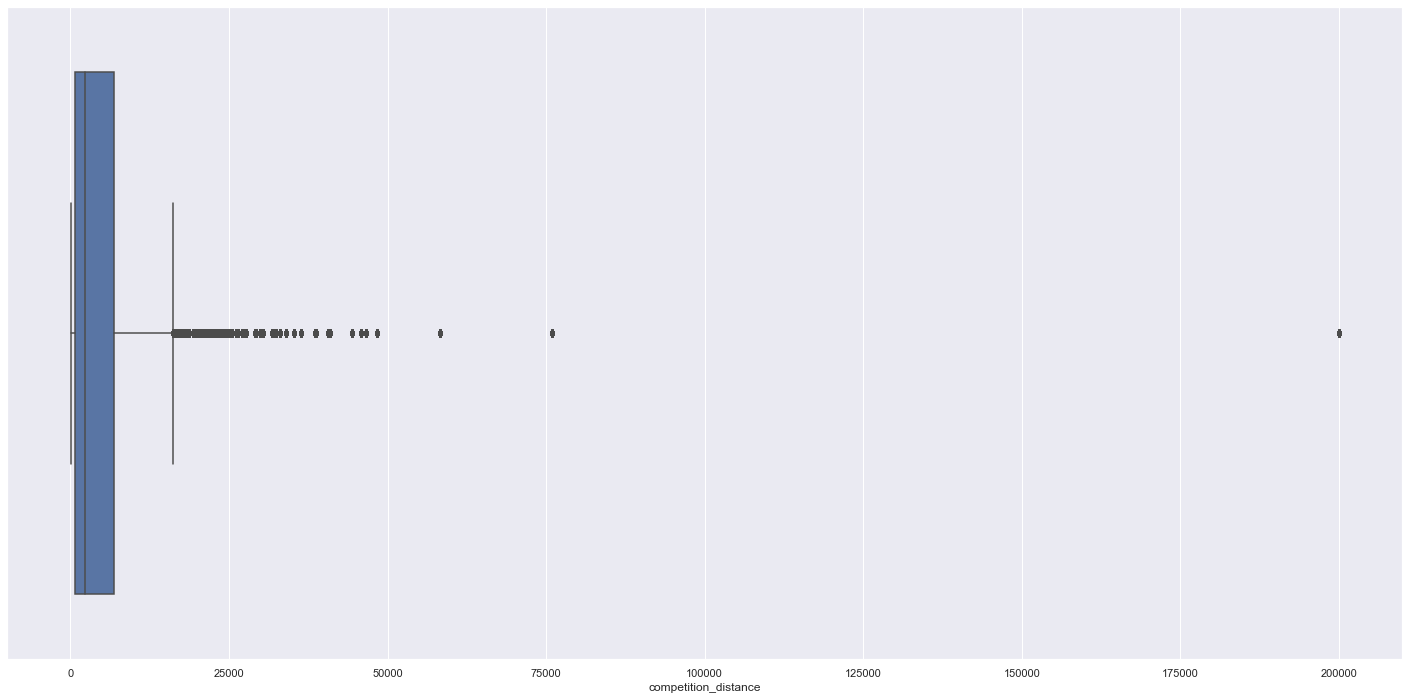

In [66]:
sns.boxplot(x = 'competition_distance', data = df5)

<AxesSubplot:xlabel='competition_time_month'>

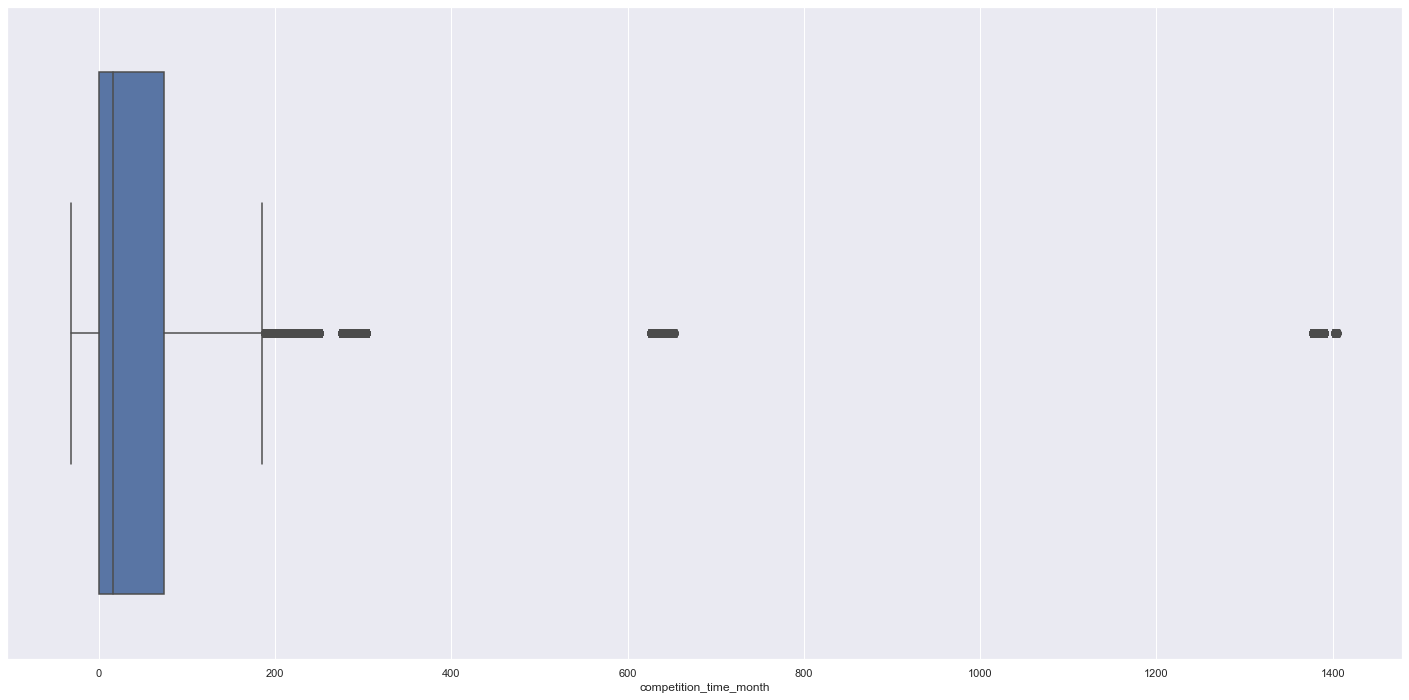

In [67]:
sns.boxplot(x = 'competition_time_month', data = df5)

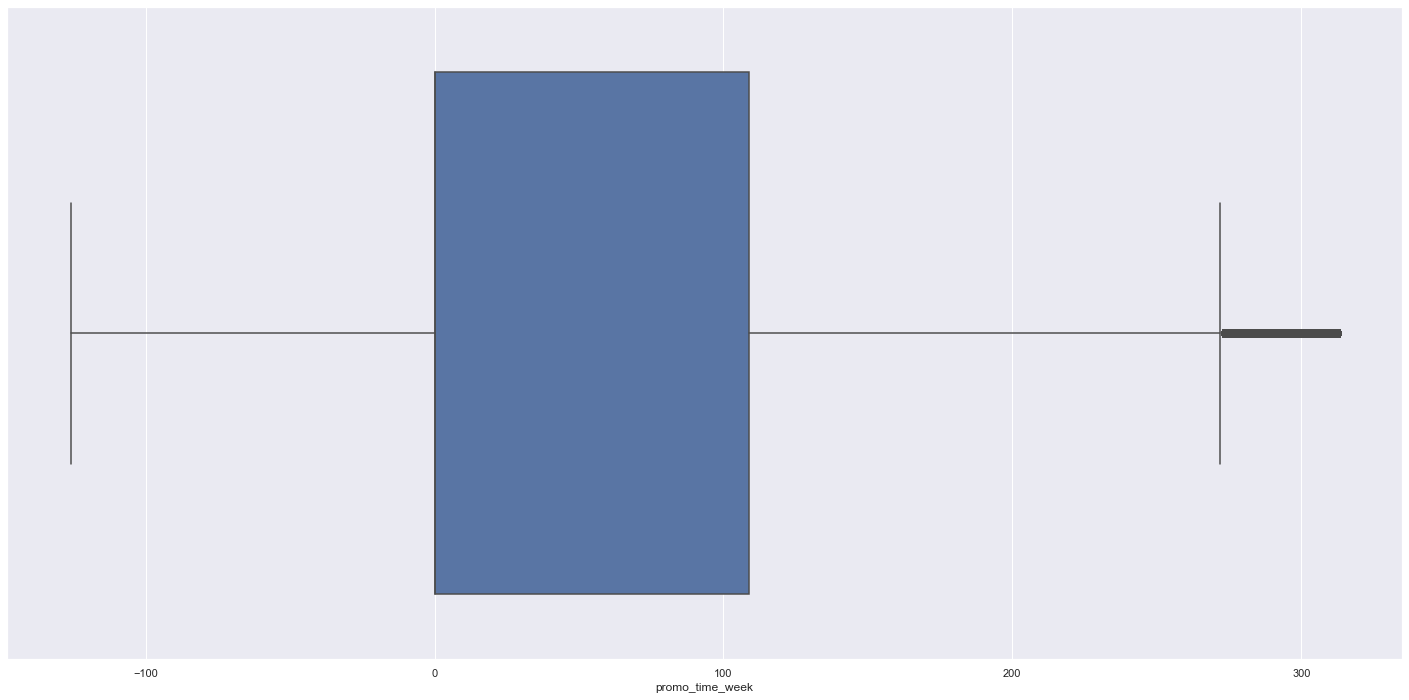

In [68]:
sns.boxplot(x = 'promo_time_week', data = df5);

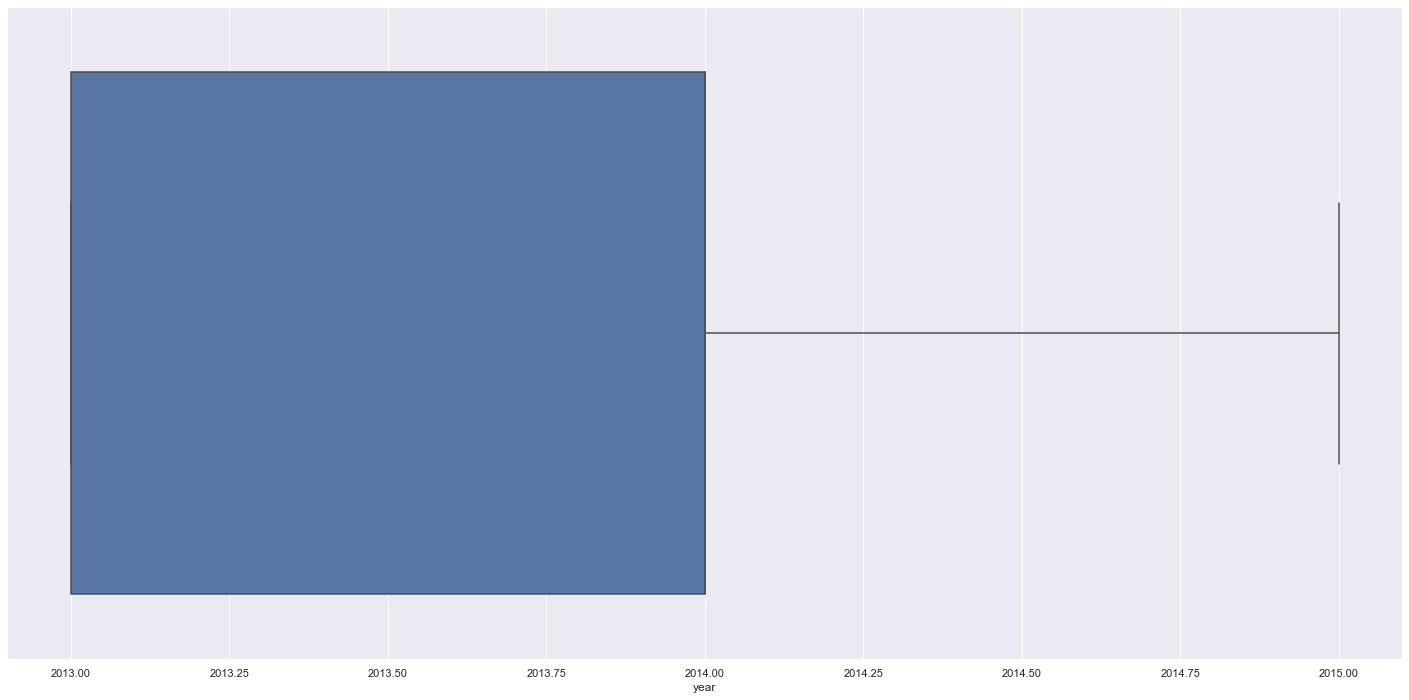

In [69]:
sns.boxplot(x = 'year', data = df5);

#### Normalizando variáveis, respeitando a indicação de outliers para definir o método

In [185]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl','wb') )


# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl','wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl','wb') )


# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl','wb') )



C:\Users\Eric\.conda\envs\DataScience_Em_Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


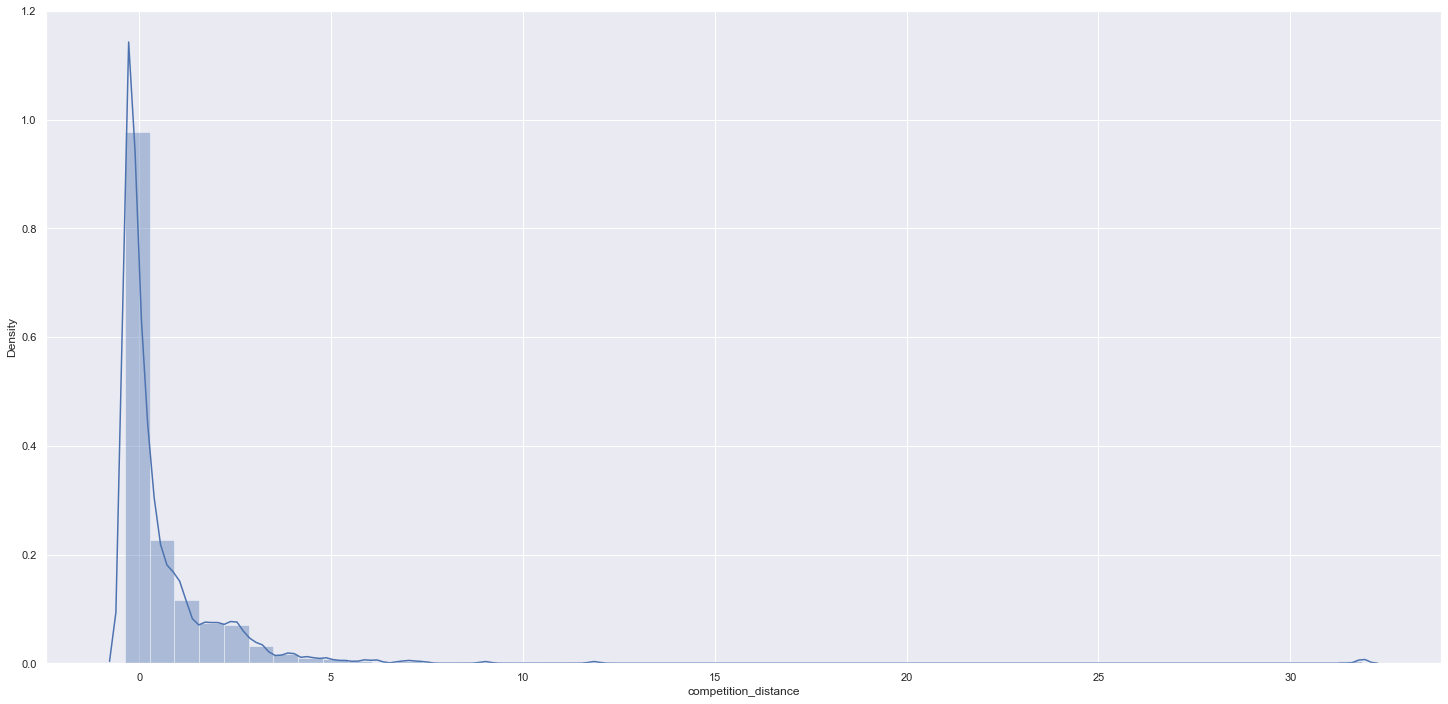

In [71]:
sns.distplot(df5['competition_distance']);

## 5.3. Transformação

### 5.3.1 Encoding

In [184]:
# state_holiday (one hot encoding)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type (label Encoding)
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump( le, open( 'parameter/store_type_scaler.pkl','wb') )

# assortment (Ordinal Encoding)
assortment_dict = {'basic' : 1,'extra' : 2,'extended' : 3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

### 5.3.2. Response Variable Transformation

In [73]:
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3 Nature Transformation

In [74]:
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x *( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x *( 2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x *( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x *( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x *( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x *( 2. * np.pi/12 ) ) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.cos(x *( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x *( 2. * np.pi/30 ) ) )


# 6.0. PASSO 06 - FEATURE SELECTION

In [75]:
df6 = df5.copy()

## 6.1.Split dataframe into training an test dataset

In [76]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.568065,-0.822984,-0.974928,-0.222521,-0.5,-0.866025,0.978148,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.568065,-0.822984,-0.974928,-0.222521,-0.5,-0.866025,0.978148,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.568065,-0.822984,-0.974928,-0.222521,-0.5,-0.866025,0.978148,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.568065,-0.822984,-0.974928,-0.222521,-0.5,-0.866025,0.978148,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.568065,-0.822984,-0.974928,-0.222521,-0.5,-0.866025,0.978148,0.978148


In [77]:
#Necessário retirar váriaveis que foram derivadas.
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [78]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [79]:
# necessário separar o DataSet em Treino e Teste

# Para isso utilizaremos a data como determinante para separação

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2.1. Boruta as Feature Selector

In [80]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date','sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

In [81]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [82]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'week_of_year_cos',
     'week_of_year_sin',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos']

#columns to add
feat_to_add = ['date', 'sales']

# final features
#cols_selected_boruta.extend( feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [83]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'date',
 'sales']

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [96]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

x_training = X_train[ cols_selected_boruta_full]

## 7.1. Average Model

In [85]:
# model
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result                                                   

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression

In [86]:
# model
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test), np.expm1( yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1871.431289,0.294961,2671.508559


In [87]:
## RMSE aumentou o erro no modelo linear, modelo de média é melhor que o de regressão linear.

### 7.2.1. Linear Regression Model Cross Validation

In [100]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.94 +/- 290.15,0.3 +/- 0.02,2951.18 +/- 459.98


## 7.3. Linear Regression Regularized Model - Lasso

In [88]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test), np.expm1( yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1892.34917,0.289522,2744.193205


In [89]:
## RMSE continua sendo melhor no modelo de média, o fenomeno 
## que estamos analisando se mostra ser mais complexo do que as soluções lineares

### 7.3.1. Lasso - Cross Validatition

In [101]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.42 +/- 340.4,0.29 +/- 0.01,3057.45 +/- 502.37


## 7.4. Random Forest Regressor

In [90]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test), np.expm1( yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,671.360511,0.100877,984.047489


### 7.4.1 Random Forest Regressor -  Cross Validation

In [102]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,843.94 +/- 221.46,0.12 +/- 0.02,1289.02 +/- 359.41


## 7.5. XGBoost Regressor

In [91]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.09).fit( x_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error( 'XGB Regressor', np.expm1( y_test), np.expm1( yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,872.679372,0.127436,1282.945527


### 7.5.1 XGBoost Regressor Cross Validation

In [103]:
xgb_result_cv = cross_validation( x_training, 5, 'XGB Regressor', model_xgb, verbose=True)



Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


In [174]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Regressor,1038.86 +/- 191.52,0.14 +/- 0.02,1527.18 +/- 305.12


## 7.6. Compare Model´s Performance

### 7.6.1. Single Performace

In [92]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,671.360511,0.100877,984.047489
0,XGB Regressor,872.679372,0.127436,1282.945527
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1871.431289,0.294961,2671.508559
0,Linear Regression - Lasso,1892.349170,0.289522,2744.193205


In [94]:
model = Lasso( alpha=0.01 )
a = cross_validation( x_training, 5, 'Lasso', model )

### 7.6.2. Real Performace - Cross Validation

In [108]:
modelling_result_cv  = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.94 +/- 290.15,0.3 +/- 0.02,2951.18 +/- 459.98
0,Lasso,2116.42 +/- 340.4,0.29 +/- 0.01,3057.45 +/- 502.37
0,Random Forest Regressor,843.94 +/- 221.46,0.12 +/- 0.02,1289.02 +/- 359.41
0,XGB Regressor,1038.86 +/- 191.52,0.14 +/- 0.02,1527.18 +/- 305.12


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [123]:
# param = {
    # 'n_estimators': [1500 , 1700, 2500, 3000, 3500],
   # 'eta': [0.01, 0.03],
   # 'max_depth': [3, 5, 9],
   # 'subsample': [0.1, 0.5, 0.7],
   # 'colsample_bytee': [0.3, 0.7, 0.9],
   # 'min_child_weight': [3, 8, 15]
   #    }

#MAX_EVAL = 10

In [124]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
    # chose values for parameters randomly
    #hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
    #print( hp )
    
    # model
    #model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                               #  n_estimators=hp['n_estimators'],
                               #  eta=hp['eta'],
                               #  max_depth=hp['max_depth'],
                               #  subsample=hp['subsample'],
                               #  colsample_bytee=hp['colsample_bytee'],
                               # min_child_weight=hp['min_child_weight'])

    # performance
    
    #result =cross_validation( x_training, 2, 'XGB Regressor', model_xgb, verbose=False)
    #final_result = pd.concat( [final_result, result])
    
#final_result

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.9, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsampl

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Regressor,886.8 +/- 110.14,0.12 +/- 0.01,1258.7 +/- 170.97
0,XGB Regressor,899.72 +/- 128.61,0.12 +/- 0.01,1285.38 +/- 209.47
0,XGB Regressor,873.5 +/- 135.82,0.12 +/- 0.02,1255.77 +/- 208.31
0,XGB Regressor,837.86 +/- 99.56,0.11 +/- 0.01,1208.16 +/- 167.45
0,XGB Regressor,858.89 +/- 113.53,0.12 +/- 0.01,1225.08 +/- 180.2
0,XGB Regressor,880.51 +/- 104.52,0.12 +/- 0.01,1253.67 +/- 165.9
0,XGB Regressor,862.56 +/- 111.17,0.12 +/- 0.01,1229.53 +/- 181.34
0,XGB Regressor,911.11 +/- 125.85,0.12 +/- 0.01,1297.42 +/- 208.32
0,XGB Regressor,905.22 +/- 120.6,0.12 +/- 0.01,1281.28 +/- 185.0
0,XGB Regressor,909.89 +/- 84.84,0.12 +/- 0.01,1299.89 +/- 144.95


In [126]:
#	Model Name	MAE CV	MAPE CV	RMSE CV
#0	XGB Regressor	886.8 +/- 110.14	0.12 +/- 0.01	1258.7 +/- 170.97
#0	XGB Regressor	899.72 +/- 128.61	0.12 +/- 0.01	1285.38 +/- 209.47
#0	XGB Regressor	873.5 +/- 135.82	0.12 +/- 0.02	1255.77 +/- 208.31
#0	XGB Regressor	837.86 +/- 99.56	0.11 +/- 0.01	1208.16 +/- 167.45
#0	XGB Regressor	858.89 +/- 113.53	0.12 +/- 0.01	1225.08 +/- 180.2
#0	XGB Regressor	880.51 +/- 104.52	0.12 +/- 0.01	1253.67 +/- 165.9
#0	XGB Regressor	862.56 +/- 111.17	0.12 +/- 0.01	1229.53 +/- 181.34
#0	XGB Regressor	911.11 +/- 125.85	0.12 +/- 0.01	1297.42 +/- 208.32
#0	XGB Regressor	905.22 +/- 120.6	0.12 +/- 0.01	1281.28 +/- 185.0
#0	XGB Regressor	909.89 +/- 84.84	0.12 +/- 0.01	1299.89 +/- 144.95

## 8.2. Final Model

In [128]:
param_tuned = {
    'n_estimators': 1700,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.5,
    'colsample_bytee': 0.7,
    'min_child_weight': 8
        }

In [129]:
# model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=param_tuned['n_estimators'],
                                 eta=param_tuned['eta'],
                                 max_depth=param_tuned['max_depth'],
                                 subsample=param_tuned['subsample'],
                                 colsample_bytee=param_tuned['colsample_bytee'],
                                min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train)
# prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performace
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned))
# xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,690.741321,0.10229,997.853869


    Model Name	         MAE	    MAPE	RMSE
0	XGBoost Regressor	690.741321	0.10229	997.853869

In [144]:
# mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
# mpe

-0.008739516574888088

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [147]:
df9 = X_test[ cols_selected_boruta_full]

# rescale

df9['sales'] =  np.expm1( df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [154]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [160]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106067.062500,102710.387760,109423.737240,3356.674740,0.576890
908,909,237059.578125,229255.074495,244864.081755,7804.503630,0.532063
875,876,206341.687500,202378.667661,210304.707339,3963.019839,0.319618
594,595,377220.843750,373112.947411,381328.740089,4107.896339,0.283115
721,722,355876.406250,353806.665461,357946.147039,2069.740789,0.271418


In [159]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1106,1107,232872.781250,232061.666306,233683.896194,811.114944,0.127737
959,960,256882.328125,256253.027265,257511.628985,629.300860,0.085230
782,783,252841.562500,252238.005886,253445.119114,603.556614,0.086096
245,246,253375.562500,252681.802985,254069.322015,693.759515,0.093544
672,673,282616.875000,281829.924290,283403.825710,786.950710,0.091797


<AxesSubplot:xlabel='store', ylabel='MAPE'>

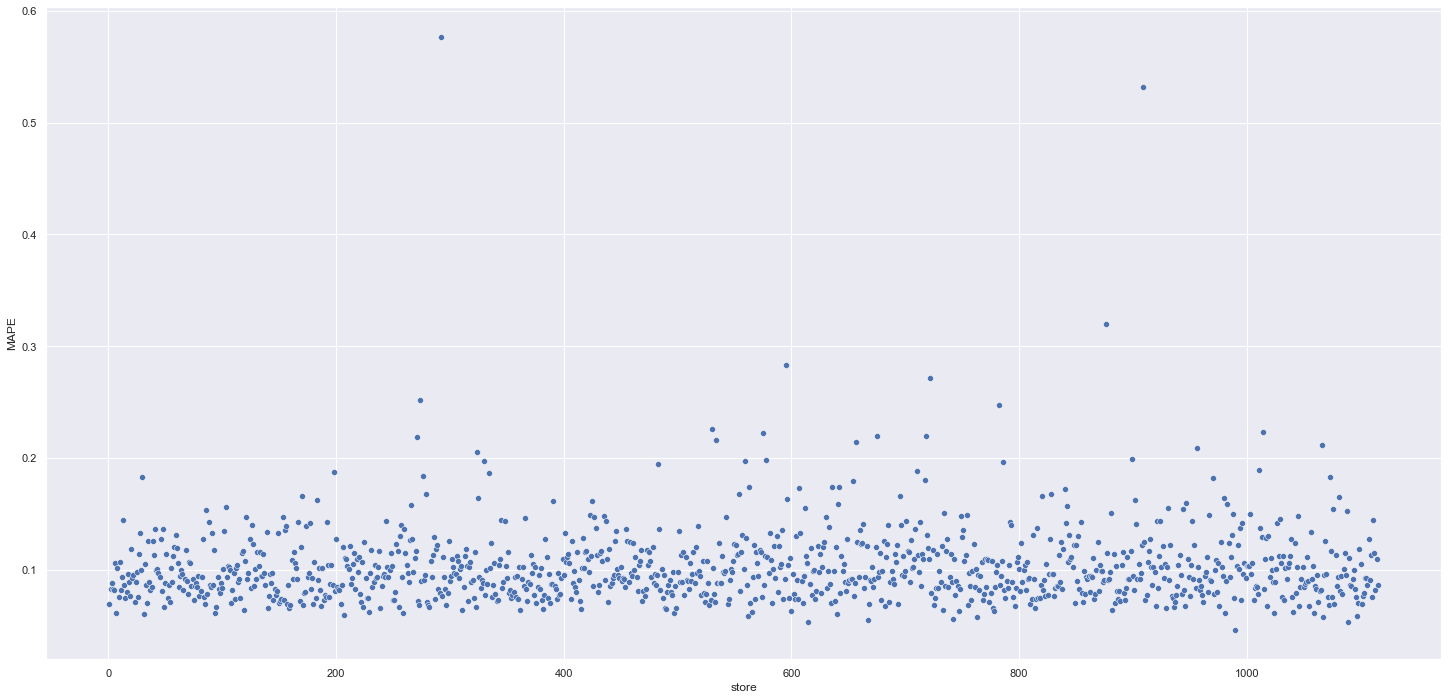

In [161]:
sns.scatterplot( x='store', y='MAPE', data = df92)

## 9.2. Total Performance

In [165]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$286,615,296.00"
1,worst_scenario,"R$285,841,354.58"
2,best_scenario,"R$287,389,192.64"


## 9.3. Machine Learning Performance

In [169]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

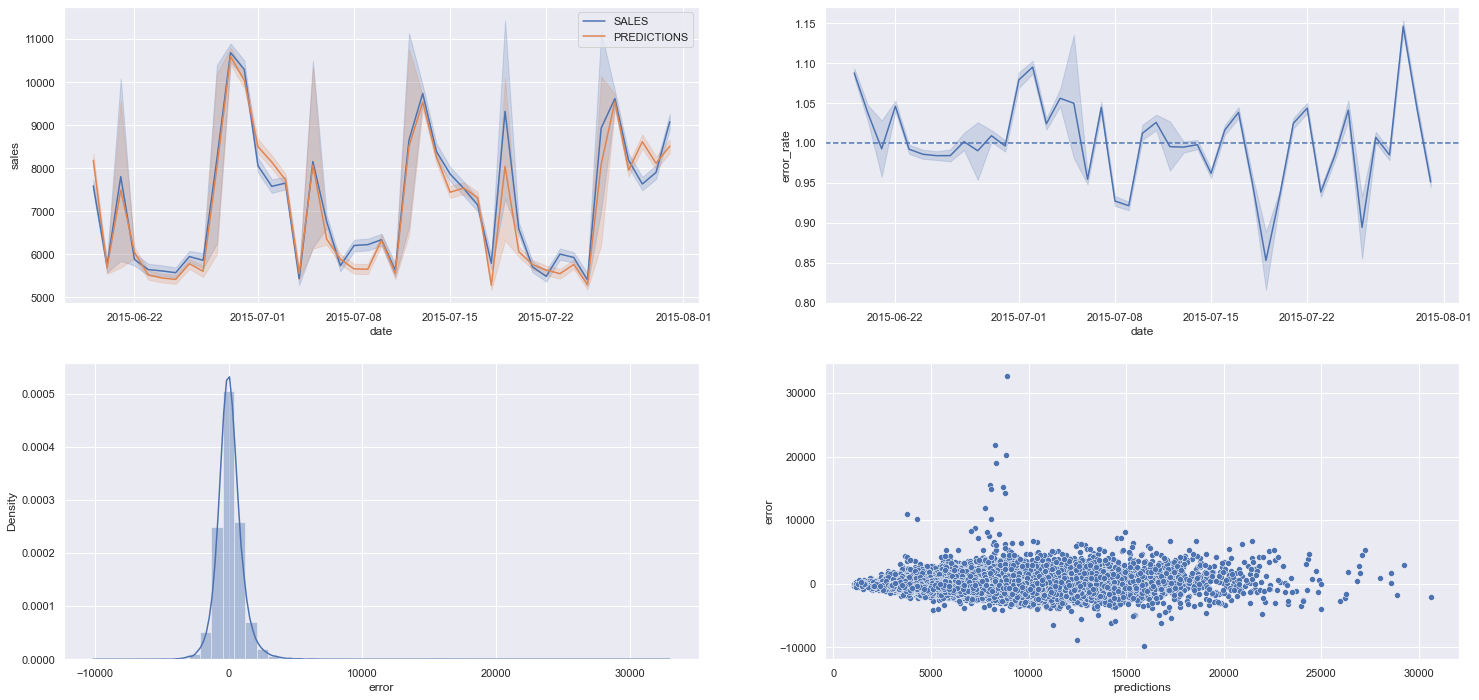

In [172]:
plt.subplot( 2,2,1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2,2,2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle= '--')

plt.subplot( 2,2,3)
sns.distplot( df9['error'])

plt.subplot( 2,2,4)
sns.scatterplot( df9['predictions'], df9['error'])

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [7]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/Eric/Repos/DataScience_Em_Producao/model/model_rossman.pkl','wb') )

NameError: name 'model_xgb_tuned' is not defined

## 10.1. Rossmann Class

In [8]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__(self):
        self.home_path='C:/Users/Eric/Repos/DataScience_Em_Producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                 'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                 'promo_time_week','week_of_year_cos','week_of_year_sin','day_of_week_sin','day_of_week_cos','month_cos',
                 'month_sin','day_sin','day_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [9]:
model = pickle.load( open( '/Users/Eric/Repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb' ) )

In [41]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/Users/Eric/Repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)


@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:  # there is data
        if isinstance(test_json, dict):  # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else:  # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # instantiate Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    port = int(os.environ.get('PORT', 33507)) 
    app.run( host = '0.0.0.0', port = port)

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [26]:
import requests

In [27]:
# loading  test dataset
df10 = pd.read_csv( '/Users/Eric/Repos/DataScience_Em_Producao/data/test.csv')

In [42]:
#merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [43]:
# convert dataframe to json
data = json.dumps(df_test.to_dict( orient='records'))

In [48]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-testando.herokuapp.com/rossmann/predict'

header = {'Content-type': 'application/json'} 

data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {} '.format( r.status_code ) )

Status Code 200 


In [45]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [46]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'. format(
            d2.loc[i,'store'], d2.loc[i,'prediction'] ) )

Store Number 20 will sell R$296,338.33 in the next 6 weeks
Store Number 22 will sell R$237,750.79 in the next 6 weeks
Store Number 23 will sell R$213,163.26 in the next 6 weeks


In [47]:
data

'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 23, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 4060.0, "CompetitionOpenSinceMonth": 8.0, "CompetitionOpenSinceYear": 2005.0, "Promo2": 0, "Promo2SinceWeek

# Branco